# Practica 3: Sensado y An&aacute;lisis Inercial 

<style>
    .imagen-ajustada {
        width: 900px;
        height: 280px;
        border-radius: 20px;
    }
</style>

<img src="Sentadillas.png" alt="Una imagen" class="imagen-ajustada">

En el notebook que se presenta a continuaci&oacute;n se tienen que procesar los datos inerciales por medio de sensores IMU, esta pr&aacute;ctica se hace con el fin de clasificar si la persona que se encuentra haciendo sentadillas lo hace de forma correcta o incorrecta, con el fin de ayudar a que se hagan de forma correcta y eviten lesiones por hacer ejercicios de forma incorrecta.
Los sensores IMU se pusieron uno en cada pantorrilla, uno en cada muslo y uno en la espalda baja del participante, siendo un total de 5 sensores. En total  fueron 10 participantes voluntarios en la toma de sus datos y as&iacute; utilizarlos en la pr&aacute;ctica, logrando as&iacute; poder entrenar nuestro modelo de forma eficiente.    

## Librer&iacute;as Importadas

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix, precision_score
from sklearn.model_selection import train_test_split
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Manejo del dataset

En esta secci&oacute;n se empieza a definir la ruta donde estan los videos para poder extraerlos y comenzar a modelarlos dentro de un dataframe.

El código carga archivos CSV desde un directorio en un diccionario, usando los nombres de archivo como claves y los contenidos como DataFrames de pandas, de manera ordenada.

In [2]:
carpeta = "./Data/"
list_df = {}

list_df = {file[:-4]: pd.read_csv(os.path.join(carpeta, file)) for file in sorted(os.listdir(carpeta))}

In [3]:
list_df['Ariana']

SensorId   TimeStamp (s)   FrameNumber   AccX (g)   AccY (g)   AccZ (g)  \
0            3            0.00             0   0.037442  -0.887220  -0.443245   
1            3            0.01             1   0.036721  -0.889475  -0.442183   
2            3            0.02             2   0.032726  -0.894212  -0.439177   
3            2           -0.00             0   0.021711  -0.998011  -0.022004   
4            2            0.01             1   0.025251  -0.997908  -0.021955   
...        ...             ...           ...        ...        ...        ...   
4666         1           20.43          1997   0.738899  -0.662809  -0.146655   
4667         3           20.32          1951  -0.029160  -0.756100  -0.575292   
4668         1           20.44          1998   0.747496  -0.671228  -0.157344   
4669         3           20.33          1952  -0.013723  -0.769684  -0.603328   
4670         1           20.45          1999   0.747009  -0.674096  -0.156266   

       GyroX (deg/s)   GyroY (deg/s)   GyroZ (deg/s)   MagX (uT)  ...  \
0          -0.368823       -1.200886       -0.566767  -25.840397  ...   
1          -0.633702       -1.097575       -0.549118  -26.308096  ...   
2          -0.988580       -1.114592       -0.672775  -25.957323  ...   
3          -0.022777        0.758312        0.276806  -52.323883  ...   
4          -0.023209        0.516617        0.291440  -52.002338  ...   
...              ...             ...             ...         ...  ...   
4666      -12.331003      -25.610823      -32.909512  -26.132710  ...   
4667      -43.811047        1.105879        2.535139  -26.863489  ...   
4668      -11.067548      -27.715807      -33.152092  -26.161942  ...   
4669      -44.257469        1.772645        3.551233  -27.389652  ...   
4670      -11.392050      -31.681248      -33.381763  -25.752703  ...   

         QuatX     QuatY     QuatZ   LinAccX (g)   LinAccY (g)   LinAccZ (g)  \
0    -0.042603 -0.010431 -0.010769      0.000900      0.000134     -0.007537   
1    -0.042544 -0.010426 -0.010663      0.001644      0.002314     -0.006192   
2    -0.043390 -0.009775 -0.010604      0.005367      0.007048     -0.003777   
3     0.003627 -0.002929 -0.006640     -0.000606      0.000704     -0.001510   
4     0.003628 -0.002905 -0.006686     -0.004193      0.000754     -0.001559   
...        ...       ...       ...           ...           ...           ...   
4666  0.182456 -0.292122 -0.114571     -0.074021      0.006754     -0.055387   
4667  0.070745  0.001073  0.128516      0.031398      0.048373     -0.044906   
4668  0.184435 -0.294731 -0.112711     -0.077722     -0.001549     -0.043593   
4669  0.074583  0.000733  0.128144      0.011367      0.032077     -0.018233   
4670  0.186581 -0.297344 -0.110546     -0.072893      0.003125     -0.036034   

       Pressure (kPa)   Altitude (m)   Temperature (degC)   HeaveMotion (m)  
0                 0.0            0.0                  0.0               0.0  
1                 0.0            0.0                  0.0               0.0  
2                 0.0            0.0                  0.0               0.0  
3                 0.0            0.0                  0.0               0.0  
4                 0.0            0.0                  0.0               0.0  
...               ...            ...                  ...               ...  
4666              0.0            0.0                  0.0               0.0  
4667              0.0            0.0                  0.0               0.0  
4668              0.0            0.0                  0.0               0.0  
4669              0.0            0.0                  0.0               0.0  
4670              0.0            0.0                  0.0               0.0  

[4671 rows x 26 columns]

In [4]:
list_df["Andrea"].columns

Index(['SensorId', ' TimeStamp (s)', ' FrameNumber', ' AccX (g)', ' AccY (g)',
       ' AccZ (g)', ' GyroX (deg/s)', ' GyroY (deg/s)', ' GyroZ (deg/s)',
       ' MagX (uT)', ' MagY (uT)', ' MagZ (uT)', ' EulerX (deg)',
       ' EulerY (deg)', ' EulerZ (deg)', ' QuatW', ' QuatX', ' QuatY',
       ' QuatZ', ' LinAccX (g)', ' LinAccY (g)', ' LinAccZ (g)',
       ' Pressure (kPa)', ' Altitude (m)', ' Temperature (degC)',
       ' HeaveMotion (m)'],
      dtype='object')

## Procesamiento de Datos

Este código se encarga de limpiar los nombres de las columnas eliminando espacios innecesarios y texto dentro de paréntesis usando expresiones regulares, y actualiza los nombres de las columnas en cada DataFrame para garantizar consistencia y facilidad de acceso a los datos.

In [5]:
# Función para limpiar los nombres de las columnas
def limpiar_nombre_columnas(nombre):
    # Elimina espacios al principio y al final, y contenido en paréntesis
    nombre_limpio = re.sub(r'\s*\([^)]*\)', '', nombre).strip()
    return nombre_limpio

# Aplicar la limpieza a los nombres de las columnas de cada DataFrame
for key, df in list_df.items():
    df.rename(columns={col: limpiar_nombre_columnas(col) for col in df.columns}, inplace=True)

In [6]:
for index in list_df:
    list_df[index]['TimeStamp'] = pd.to_datetime(list_df[index]['TimeStamp'], unit='s')

In [7]:
list_df['Andrea'].columns

Index(['SensorId', 'TimeStamp', 'FrameNumber', 'AccX', 'AccY', 'AccZ', 'GyroX',
       'GyroY', 'GyroZ', 'MagX', 'MagY', 'MagZ', 'EulerX', 'EulerY', 'EulerZ',
       'QuatW', 'QuatX', 'QuatY', 'QuatZ', 'LinAccX', 'LinAccY', 'LinAccZ',
       'Pressure', 'Altitude', 'Temperature', 'HeaveMotion'],
      dtype='object')

In [8]:
list_df['Andrea']

SensorId                  TimeStamp  FrameNumber      AccX      AccY  \
0            4 1970-01-01 00:00:00.000000            0  0.068477 -0.912087   
1            1 1970-01-01 00:00:00.000000            0  0.066376 -0.999555   
2            1 1970-01-01 00:00:00.010000            1  0.058749 -1.001864   
3            1 1970-01-01 00:00:00.020000            2  0.052185 -1.004004   
4            1 1970-01-01 00:00:00.030000            3  0.047747 -1.008838   
...        ...                        ...          ...       ...       ...   
8832         2 1970-01-01 00:00:25.630100         2299 -0.454521 -0.880524   
8833         3 1970-01-01 00:00:25.590000         2223  0.430438 -0.918506   
8834         4 1970-01-01 00:00:26.420000         2621  0.109173 -0.227898   
8835         3 1970-01-01 00:00:25.600000         2224  0.423440 -0.908016   
8836         4 1970-01-01 00:00:26.430000         2622  0.095565 -0.190173   

          AccZ      GyroX      GyroY     GyroZ       MagX  ...     QuatX  \
0    -0.383380   1.833206  -0.045396  0.063953 -23.969599  ...  0.000000   
1     0.080106  -0.186473   0.771407 -1.015720 -47.033031  ... -0.001200   
2     0.082250  -0.363923   0.525834 -0.746620 -47.091492  ... -0.001171   
3     0.081673   0.067433   0.339616 -0.618345 -46.448406  ... -0.001620   
4     0.079371   0.327756  -0.387092 -0.698904 -46.769951  ... -0.001646   
...        ...        ...        ...       ...        ...  ...       ...   
8832  0.027616   3.595888  -0.941252  2.442337 -66.004089  ... -0.130685   
8833  0.080576  -0.775975   7.144113 -8.995694 -12.160187  ... -0.058979   
8834 -0.974022 -38.953529   9.114608 -5.266281 -26.191172  ...  0.000000   
8835  0.112348  -1.892509  10.033885 -8.801491 -12.715580  ... -0.059069   
8836 -1.007332 -53.423641  -3.227295  0.088869 -26.015785  ...  0.000000   

         QuatY     QuatZ   LinAccX   LinAccY   LinAccZ  Pressure  Altitude  \
0     0.000000  0.000000  0.000000  0.000000  0.000000       0.0       0.0   
1     0.002248  0.001738 -0.000798  0.004874  0.004934       0.0       0.0   
2     0.002187  0.001685  0.007115  0.006890  0.006854       0.0       0.0   
3     0.003778  0.001716  0.013101  0.005960  0.008488       0.0       0.0   
4     0.003714  0.001747  0.015503  0.002597  0.012837       0.0       0.0   
...        ...       ...       ...       ...       ...       ...       ...   
8832  0.120562 -0.345079 -0.009045  0.025488 -0.010969       0.0       0.0   
8833 -0.202557  0.069933 -0.001030  0.034472  0.014933       0.0       0.0   
8834  0.000000  0.000000  0.000000  0.000000  0.000000       0.0       0.0   
8835 -0.203303  0.069033  0.006956  0.065329  0.003487       0.0       0.0   
8836  0.000000  0.000000  0.000000  0.000000  0.000000       0.0       0.0   

      Temperature  HeaveMotion  
0             0.0          0.0  
1             0.0          0.0  
2             0.0          0.0  
3             0.0          0.0  
4             0.0          0.0  
...           ...          ...  
8832          0.0          0.0  
8833          0.0          0.0  
8834          0.0          0.0  
8835          0.0          0.0  
8836          0.0          0.0  

[8837 rows x 26 columns]

In [9]:
for index in list_df:
    if index in ["Scarlett", "Juan", "Ariana", "Rachel"]:
        # Actualizar SensorId de 3 a 4
        list_df[index].loc[list_df[index]['SensorId'] == 3, 'SensorId'] = 4

In [10]:
for persona in ["Scarlett", "Juan", "Ariana", "Rachel"]:
    print(persona,list_df[persona]["SensorId"].value_counts())

Scarlett SensorId
2    2614
1    2379
4    2339
Name: count, dtype: int64
Juan SensorId
1    3241
4    3031
2    2878
Name: count, dtype: int64
Ariana SensorId
1    2000
4    1953
2     718
Name: count, dtype: int64
Rachel SensorId
1    2373
4    2338
2    2026
Name: count, dtype: int64


In [11]:
# Estimar los totales
for index in list_df:
    df = list_df[index]
    df['AccTotal'] = np.sqrt(df['AccX']**2 + df['AccY']**2 + df['AccZ']**2)
    df['GyroTotal'] = np.sqrt(df['GyroX']**2 + df['GyroY']**2 + df['GyroZ']**2)
    df['MagTotal'] = np.sqrt(df['MagX']**2 + df['MagY']**2 + df['MagZ']**2)
    df['EulerTotal'] = np.sqrt(df['EulerX']**2 + df['EulerY']**2 + df['EulerZ']**2)

## An&aacute;lisis Exploratorio

In [12]:
for nombre, df in list_df.items():
    print(f"Estadísticas Descriptivas para: {nombre}")
    print(df.describe())
    print("-" * 50)

Estadísticas Descriptivas para: Andrea
          SensorId                      TimeStamp  FrameNumber         AccX  \
count  8837.000000                           8837  8837.000000  8837.000000   
mean      2.654294  1970-01-01 00:00:12.300204820  1129.604956     0.087581   
min       1.000000            1970-01-01 00:00:00     0.000000    -0.529415   
25%       2.000000     1970-01-01 00:00:06.230000   552.000000    -0.120553   
50%       3.000000     1970-01-01 00:00:12.130000  1104.000000     0.067255   
75%       4.000000     1970-01-01 00:00:18.050100  1656.000000     0.288664   
max       4.000000     1970-01-01 00:00:26.430000  2622.000000     1.063124   
std       1.096461                            NaN   678.096653     0.332553   

              AccY         AccZ        GyroX        GyroY        GyroZ  \
count  8837.000000  8837.000000  8837.000000  8837.000000  8837.000000   
mean     -0.818524    -0.235155    -0.594927     0.388790    -0.539552   
min      -1.075732    -1.22

Con el an&aacute;lisis de las gr&aacute;ficas podemos conocer mejor de que van los datos, en este caso lo visualizamos por medio de los &aacute;ngulos de Euler, aceleraci&oacute;n, giroscopio y magnetr&oacute;metro.

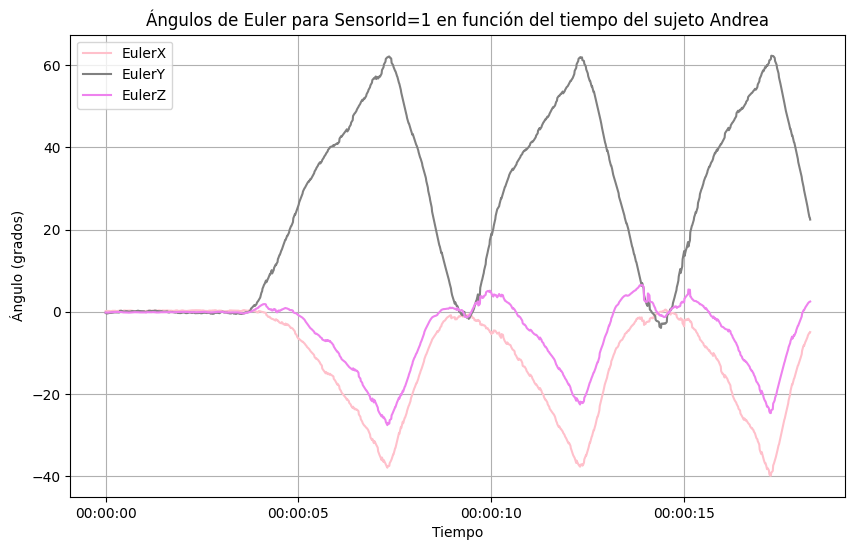

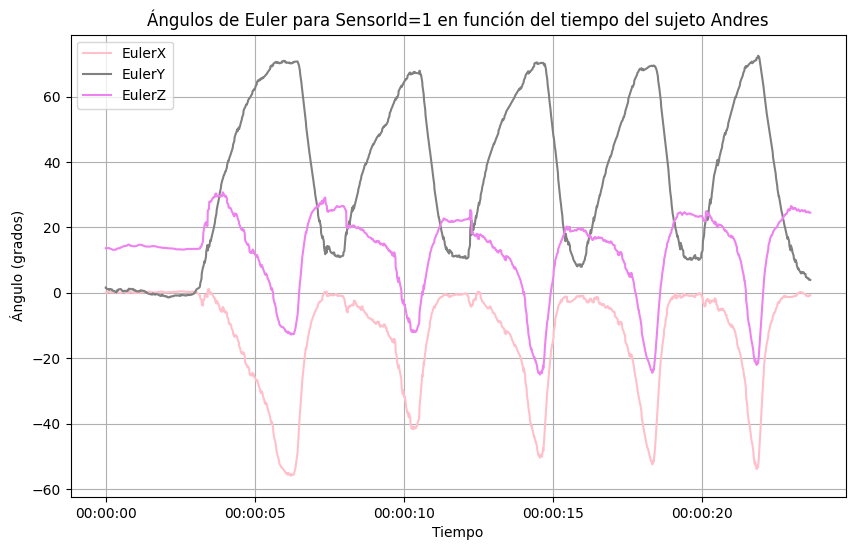

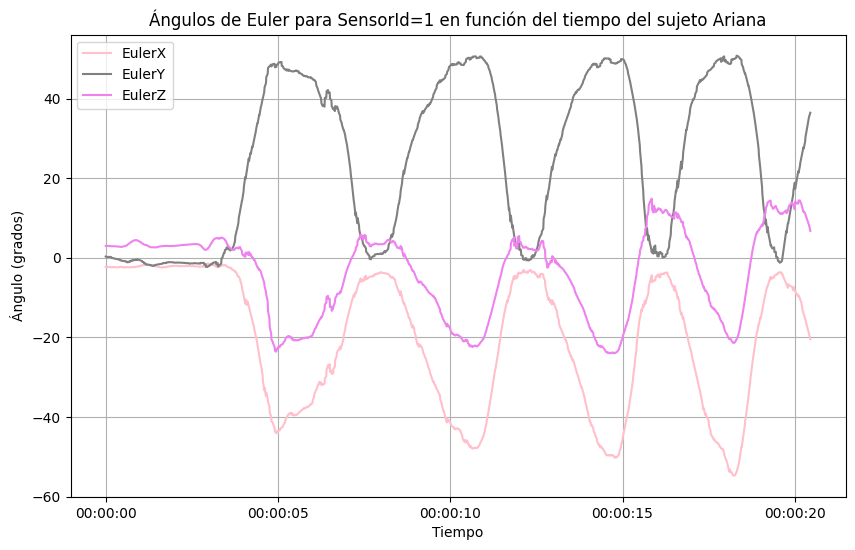

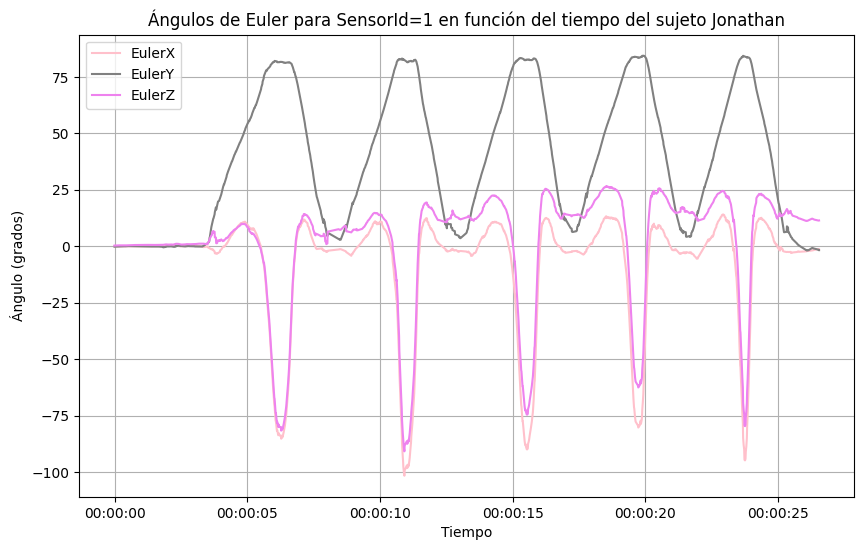

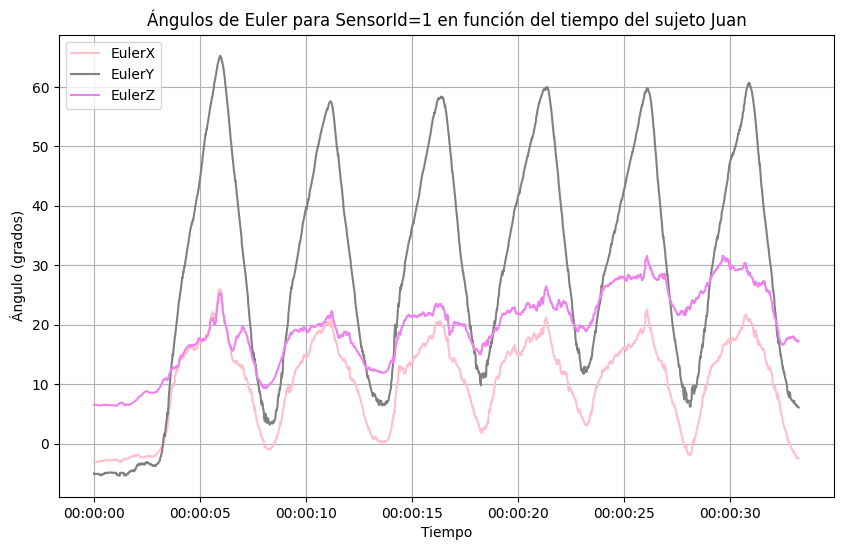

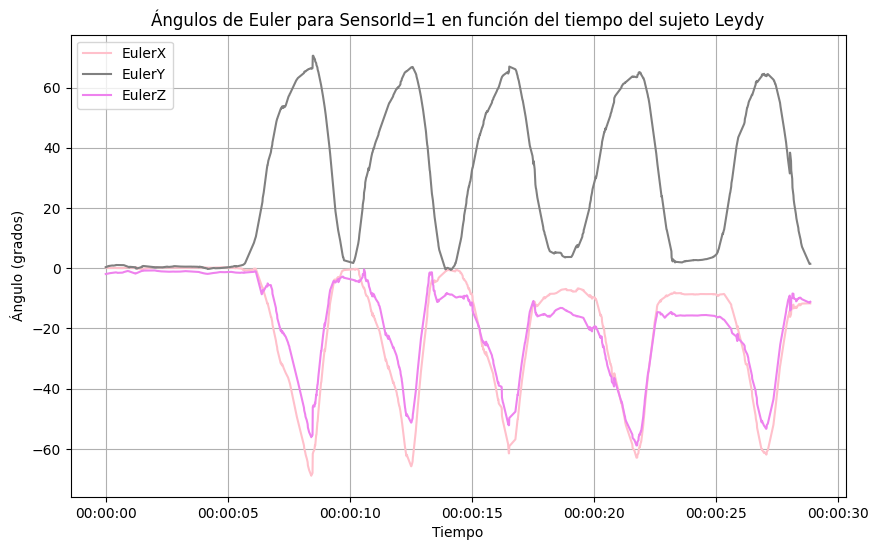

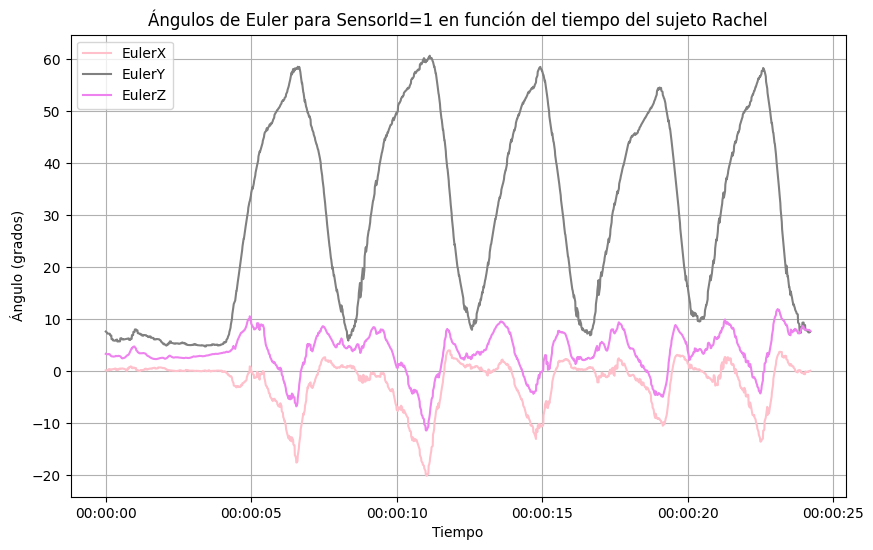

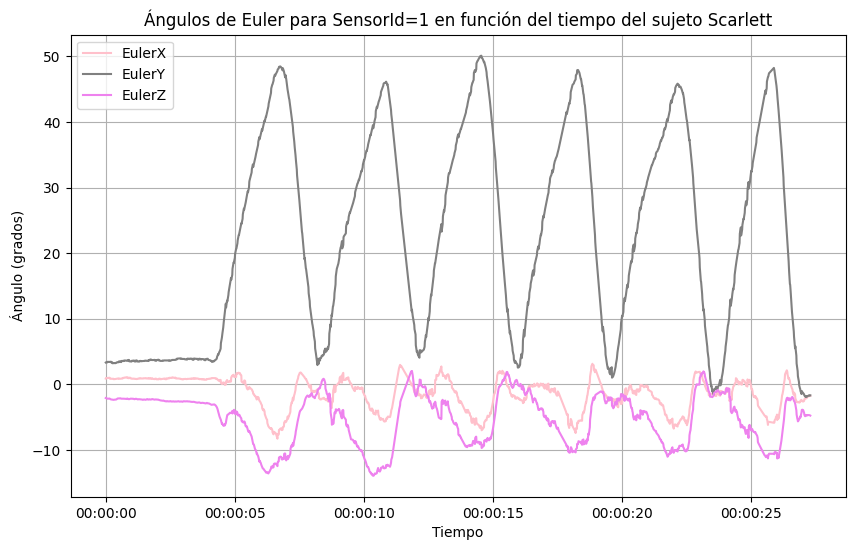

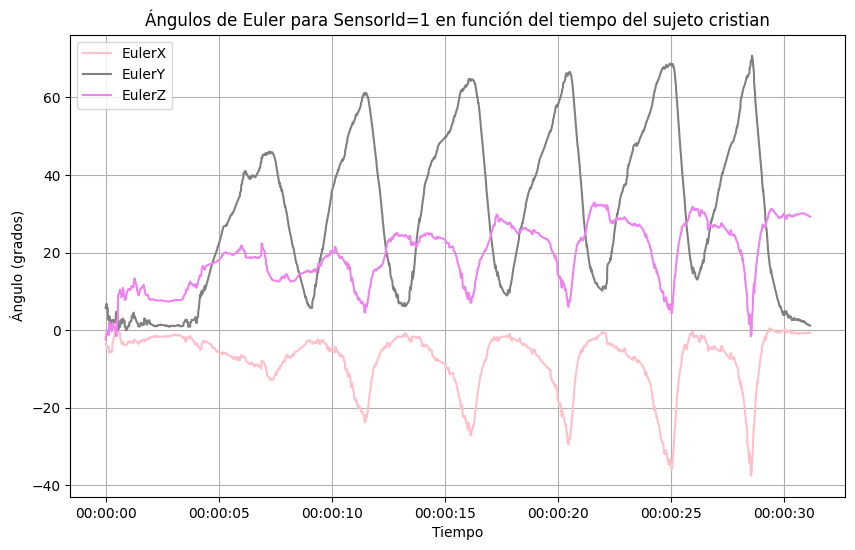

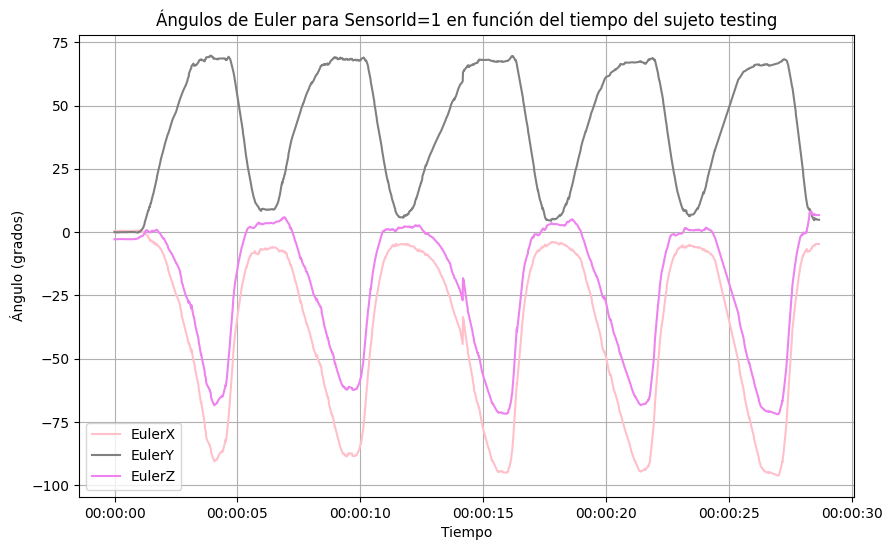

In [13]:
for index in list_df:
    df = list_df[index]
    
    df_sensor_id = df[df['SensorId'] == 1]

    plt.figure(figsize=(10, 6))
    plt.plot(df_sensor_id['TimeStamp'], df_sensor_id['EulerX'], label='EulerX', color='pink')
    plt.plot(df_sensor_id['TimeStamp'], df_sensor_id['EulerY'], label='EulerY', color='gray')
    plt.plot(df_sensor_id['TimeStamp'], df_sensor_id['EulerZ'], label='EulerZ', color='violet')
    plt.title(f'Ángulos de Euler para SensorId=1 en función del tiempo del sujeto {index}')
    plt.xlabel('Tiempo')
    plt.ylabel('Ángulo (grados)')
    plt.legend()
    plt.grid(True)
    plt.show()

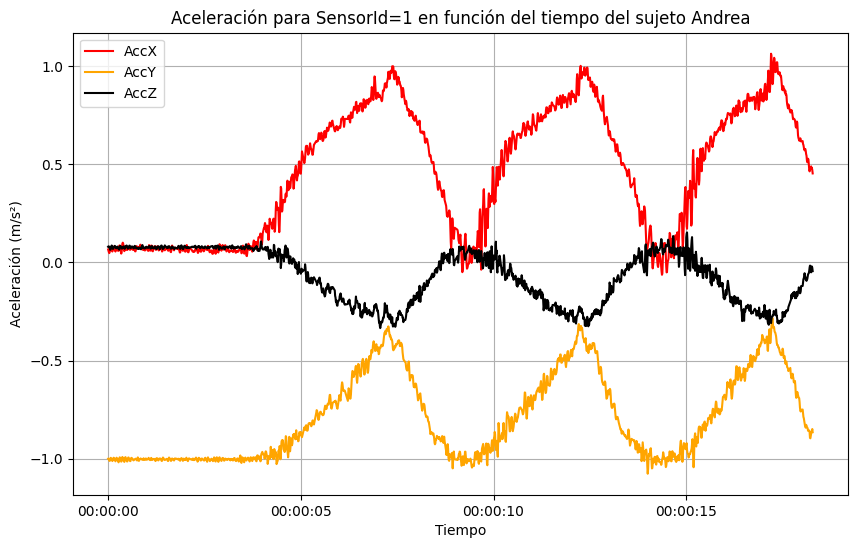

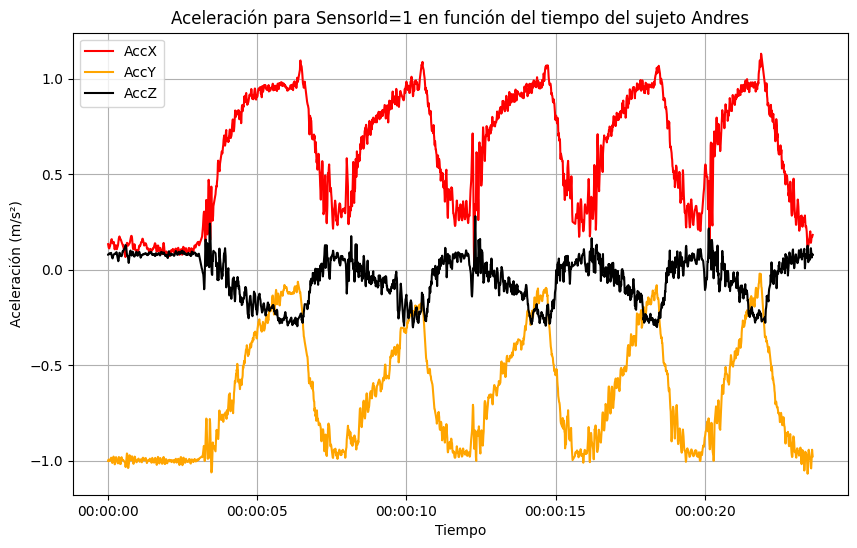

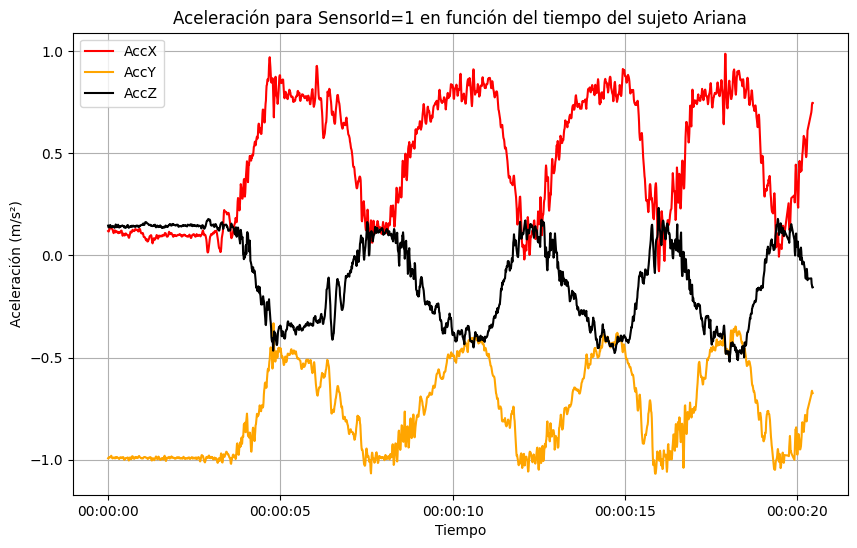

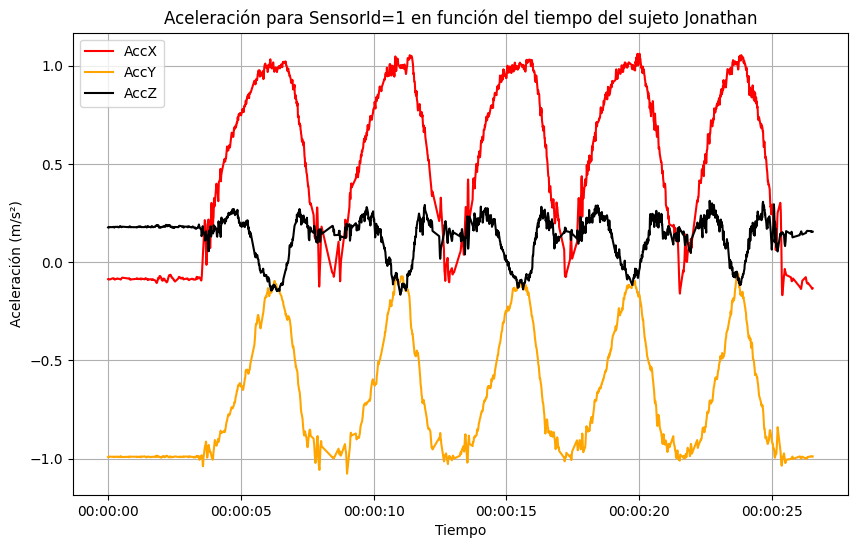

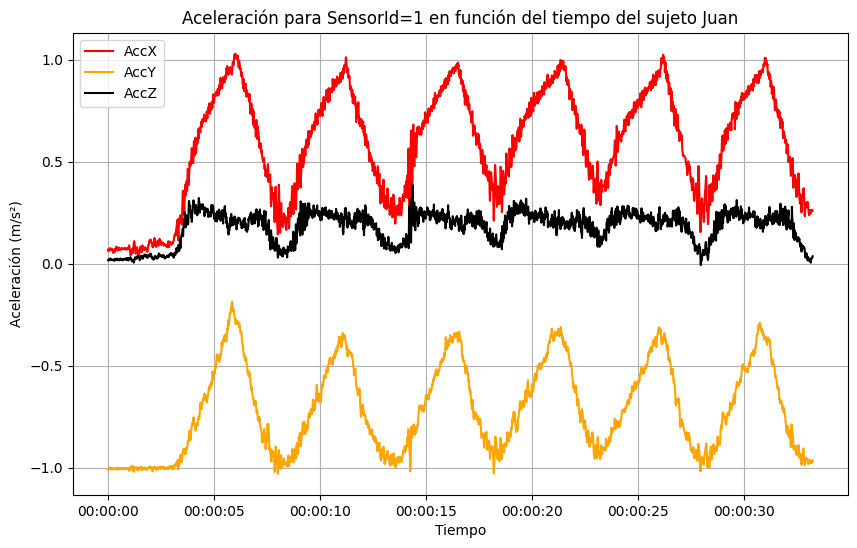

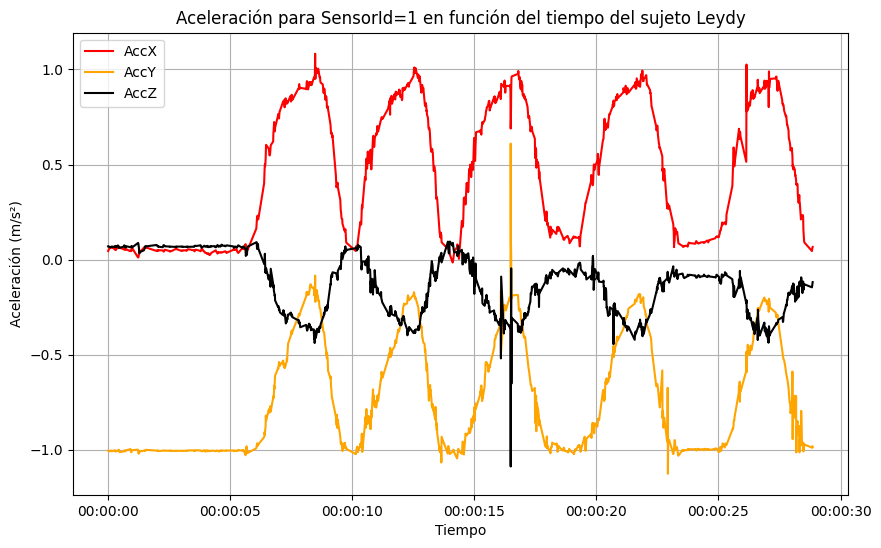

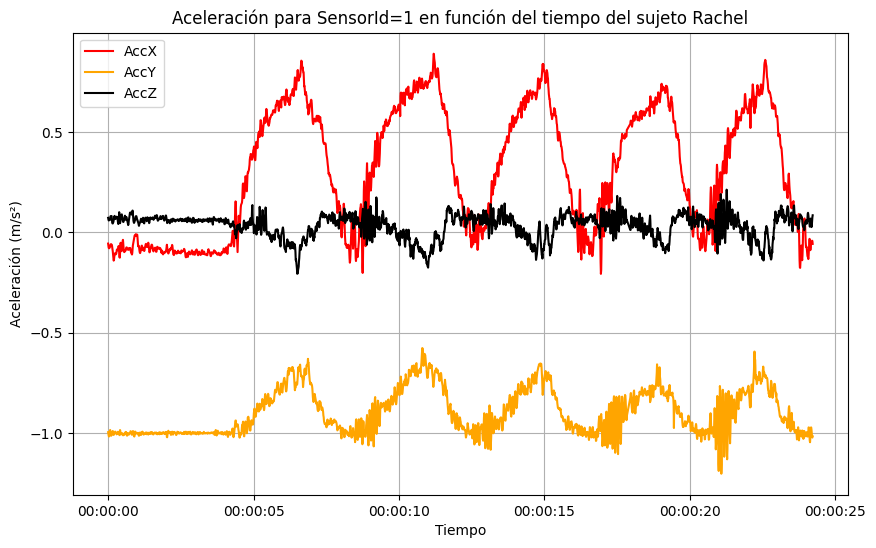

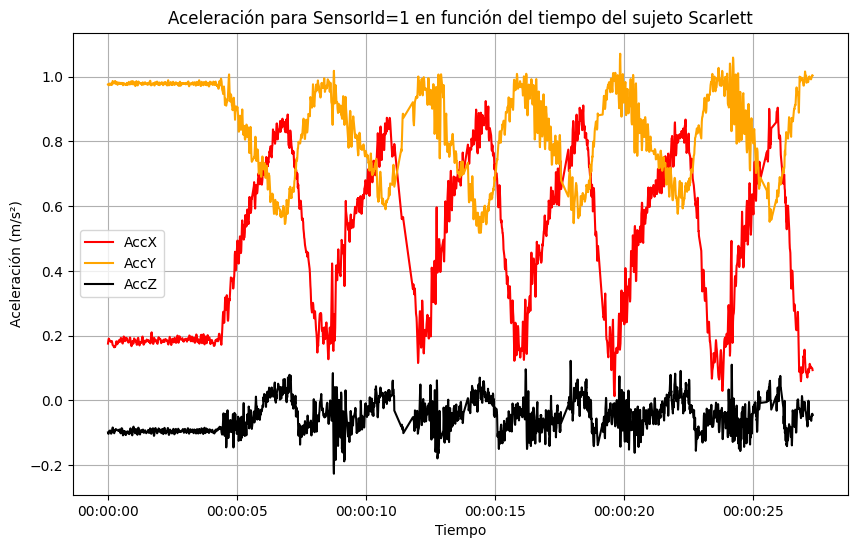

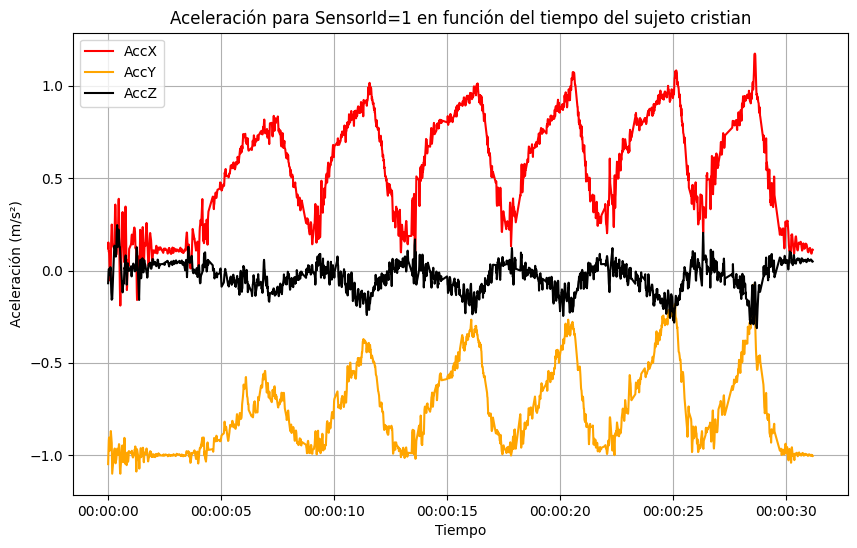

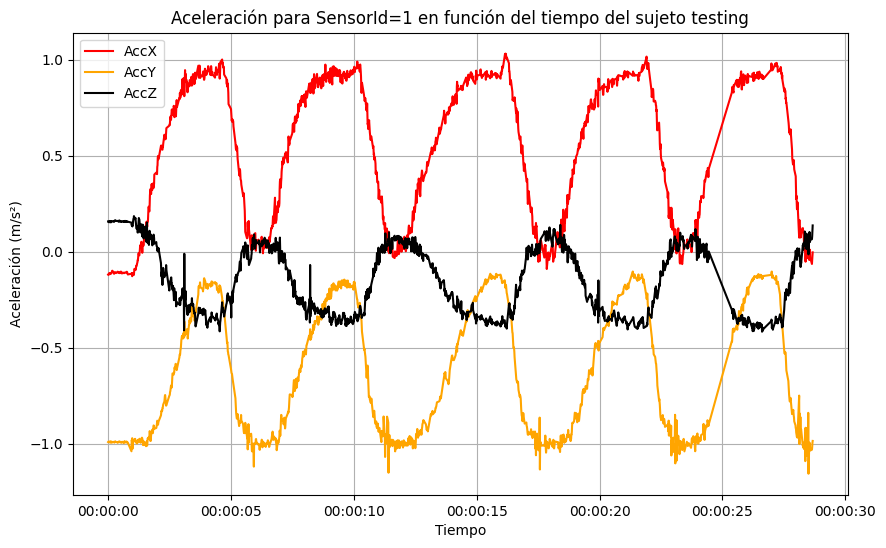

In [14]:
for index in list_df:
    df = list_df[index]
    
    df_sensor_id = df[df['SensorId'] == 1]  

    plt.figure(figsize=(10, 6))
    plt.plot(df_sensor_id['TimeStamp'], df_sensor_id['AccX'], label='AccX', color='red')
    plt.plot(df_sensor_id['TimeStamp'], df_sensor_id['AccY'], label='AccY', color='orange')
    plt.plot(df_sensor_id['TimeStamp'], df_sensor_id['AccZ'], label='AccZ', color='black')
    plt.title(f'Aceleración para SensorId=1 en función del tiempo del sujeto {index}')
    plt.xlabel('Tiempo')
    plt.ylabel('Aceleración (m/s²)')
    plt.legend()
    plt.grid(True)
    plt.show()



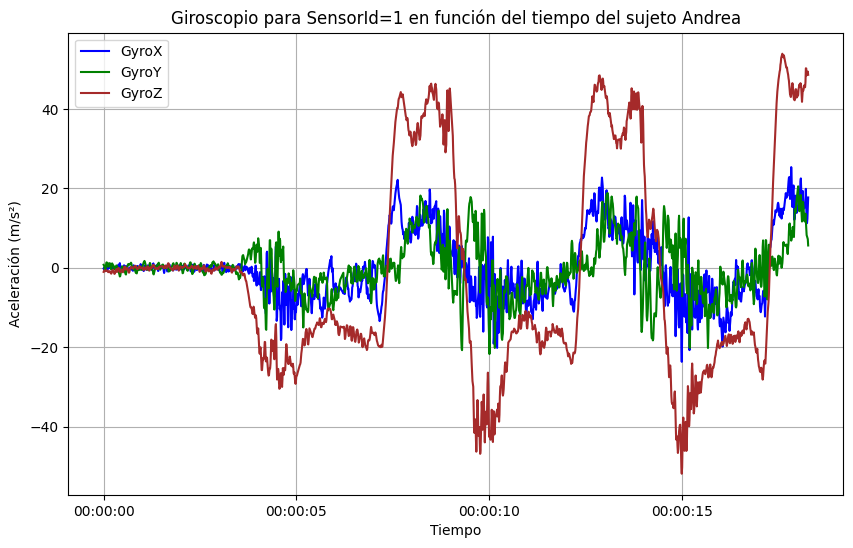

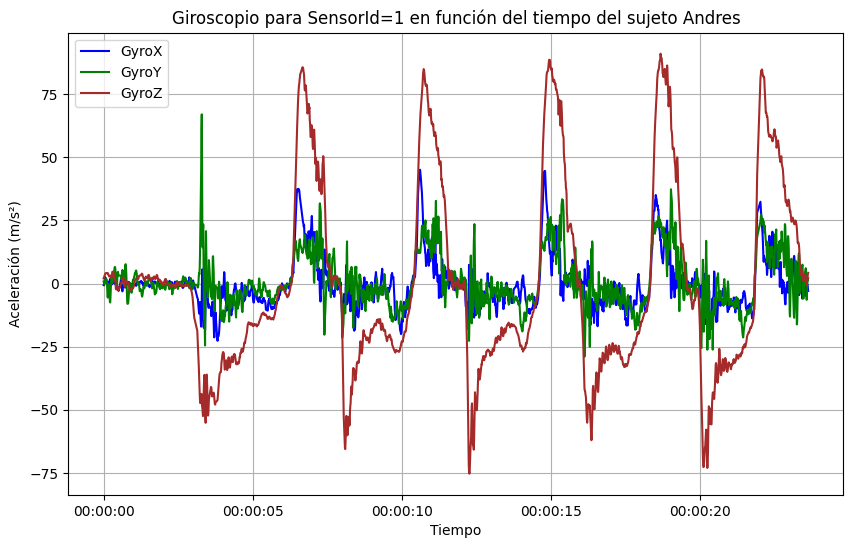

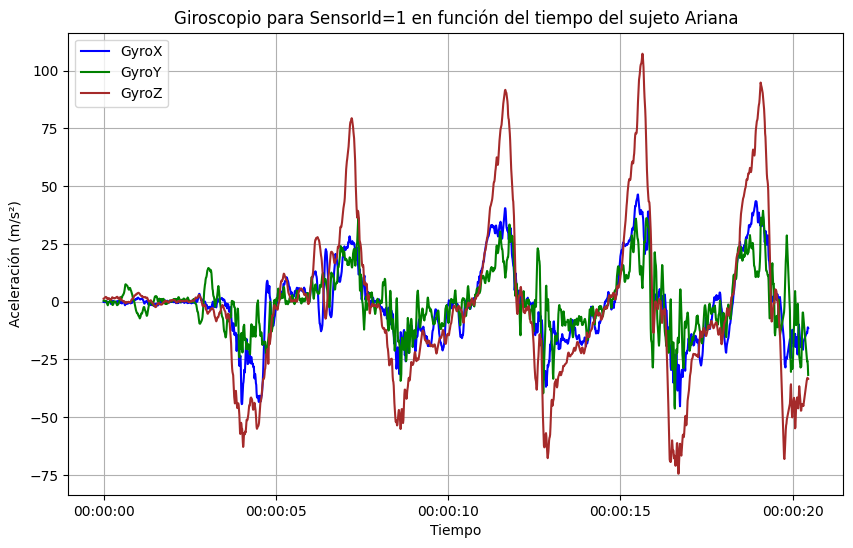

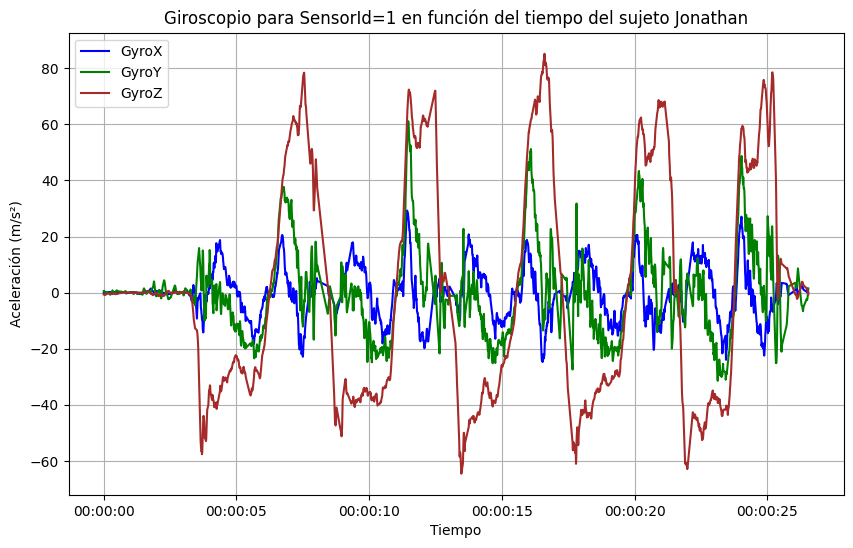

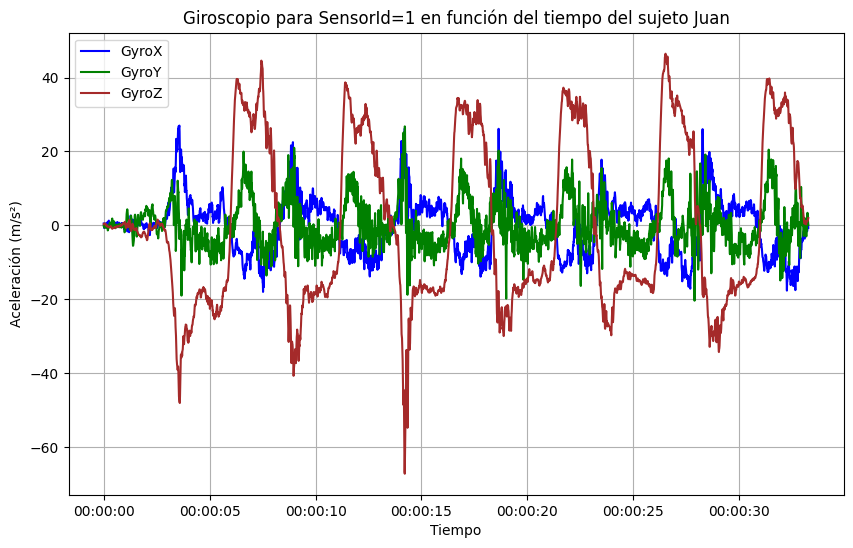

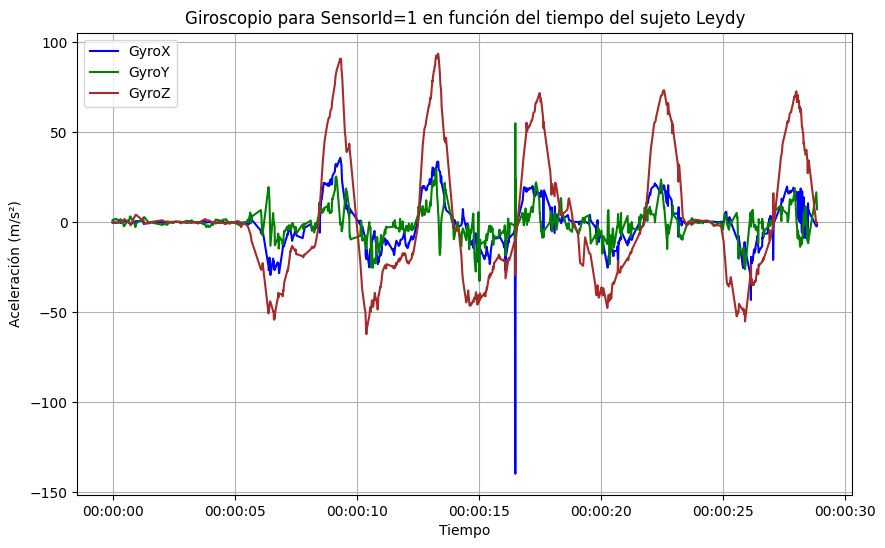

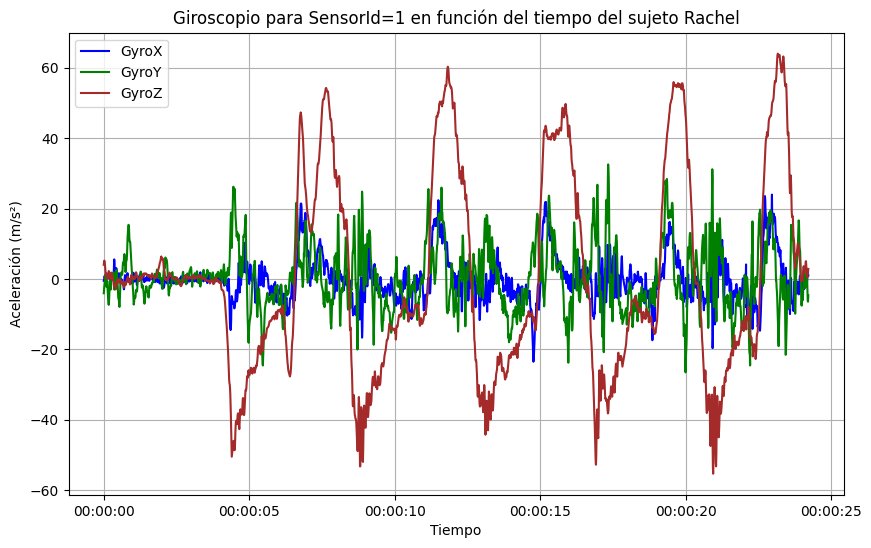

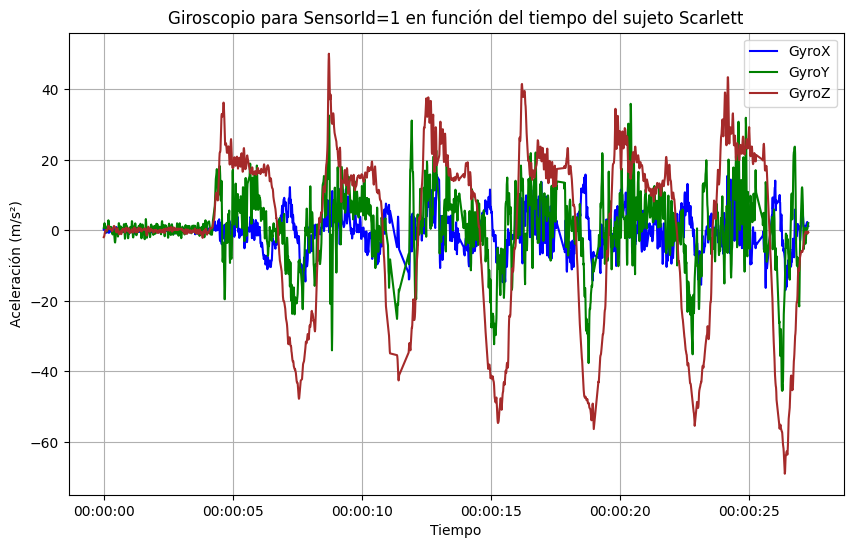

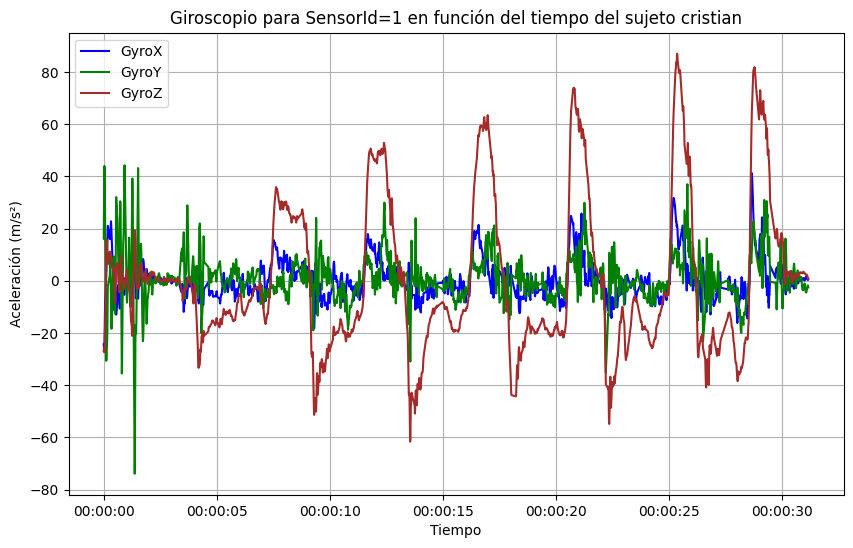

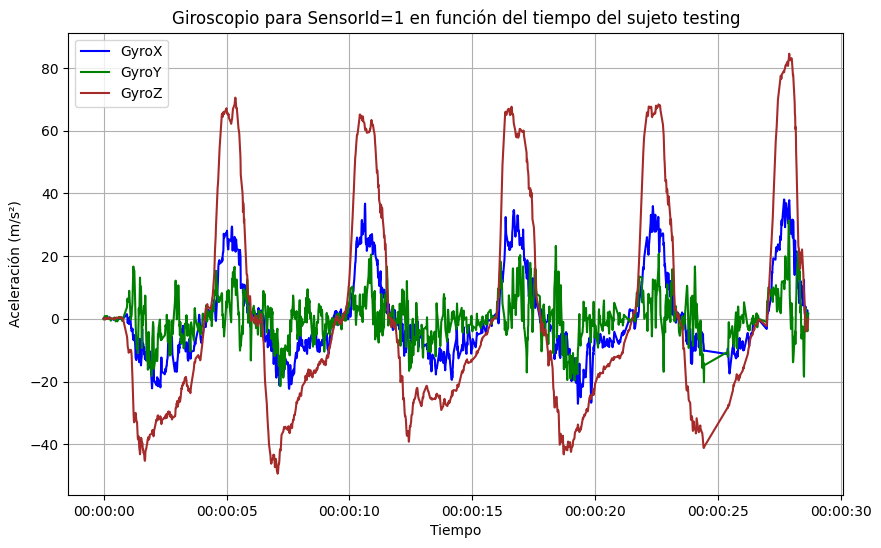

In [15]:
for index in list_df:
    df = list_df[index]
    
    df_sensor_id = df[df['SensorId'] == 1]  

    plt.figure(figsize=(10, 6))
    plt.plot(df_sensor_id['TimeStamp'], df_sensor_id['GyroX'], label='GyroX', color='blue')
    plt.plot(df_sensor_id['TimeStamp'], df_sensor_id['GyroY'], label='GyroY', color='green')
    plt.plot(df_sensor_id['TimeStamp'], df_sensor_id['GyroZ'], label='GyroZ', color='brown')
    plt.title(f'Giroscopio para SensorId=1 en función del tiempo del sujeto {index}')
    plt.xlabel('Tiempo')
    plt.ylabel('Aceleración (m/s²)')
    plt.legend()
    plt.grid(True)
    plt.show()

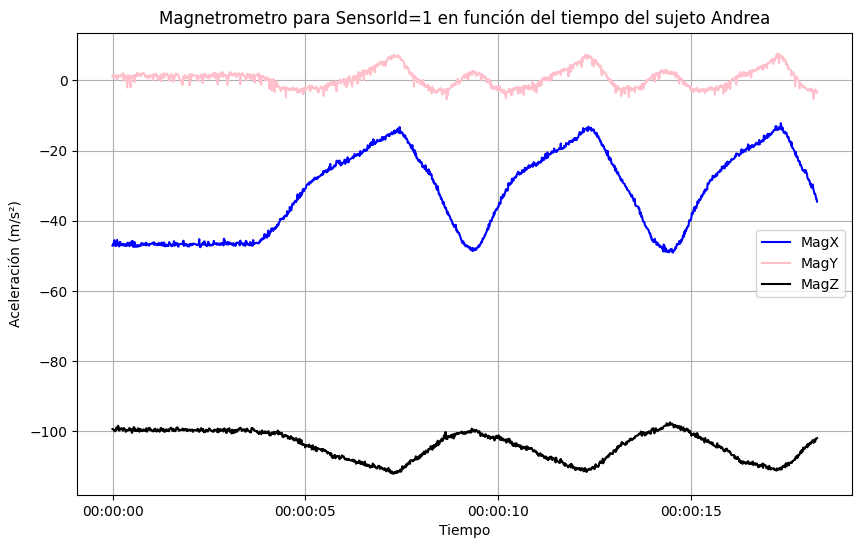

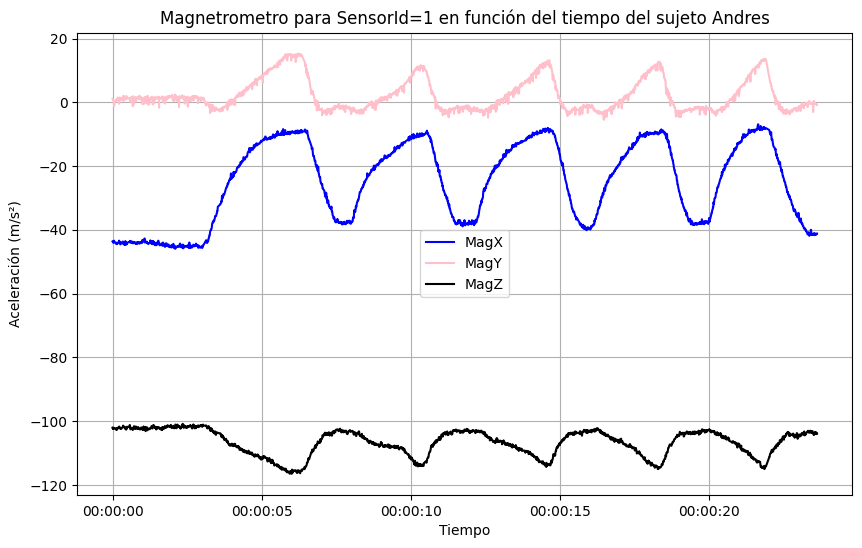

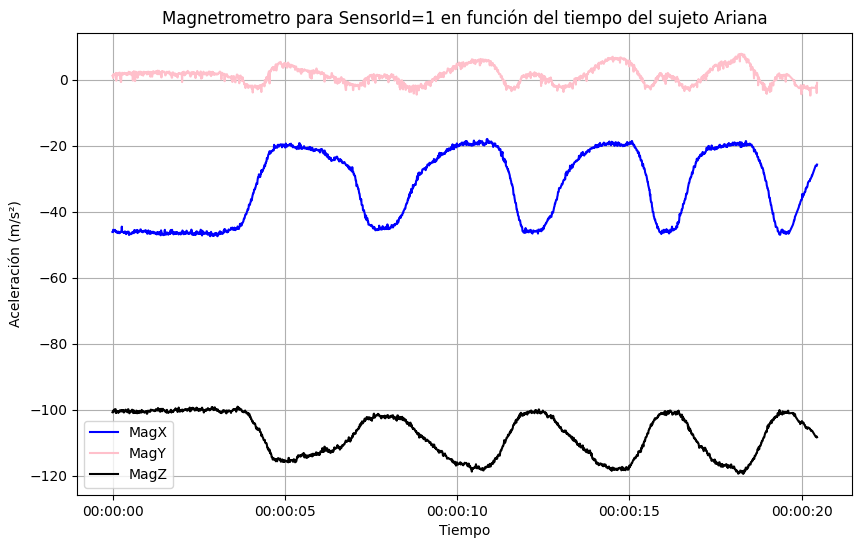

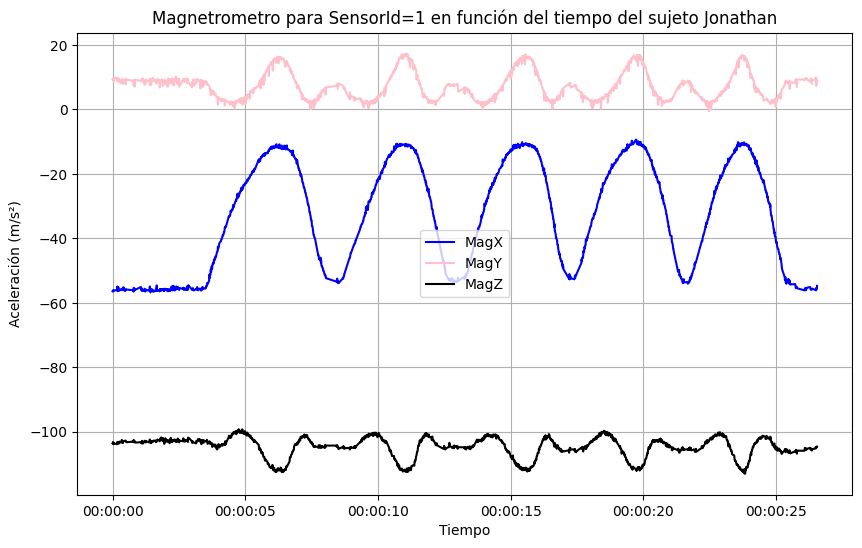

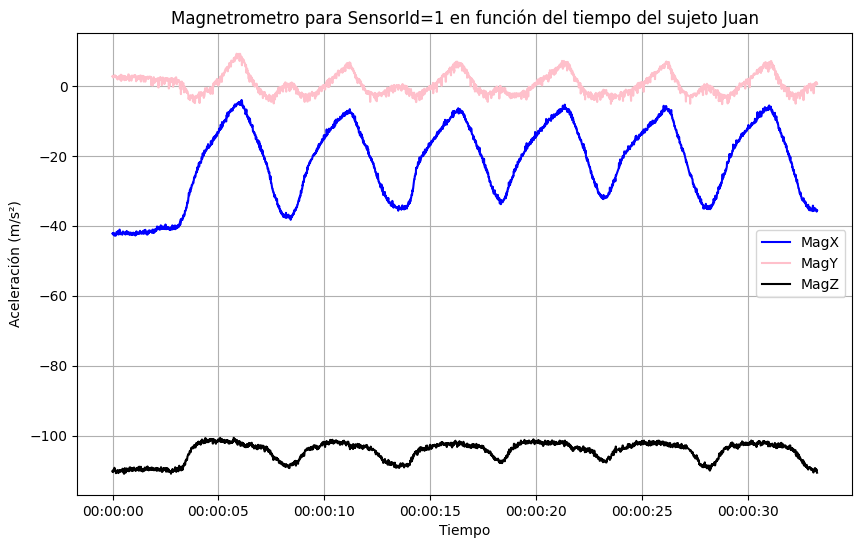

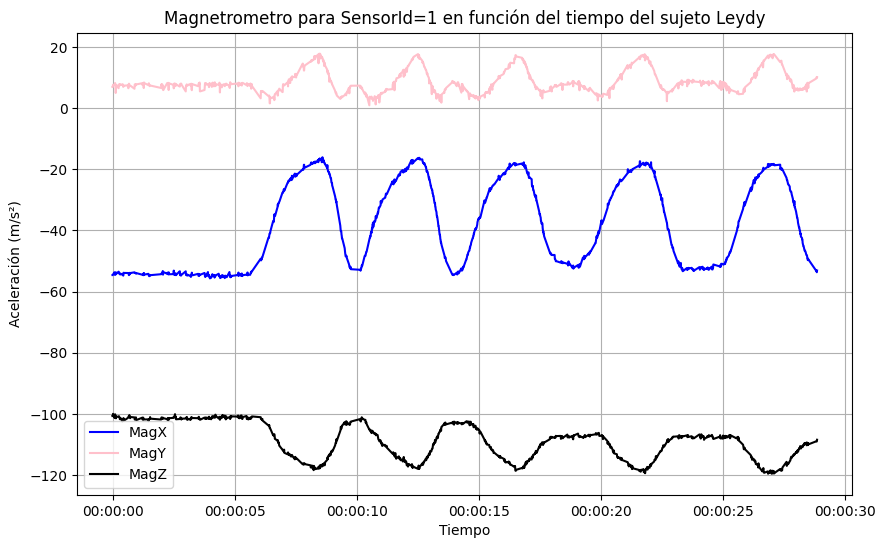

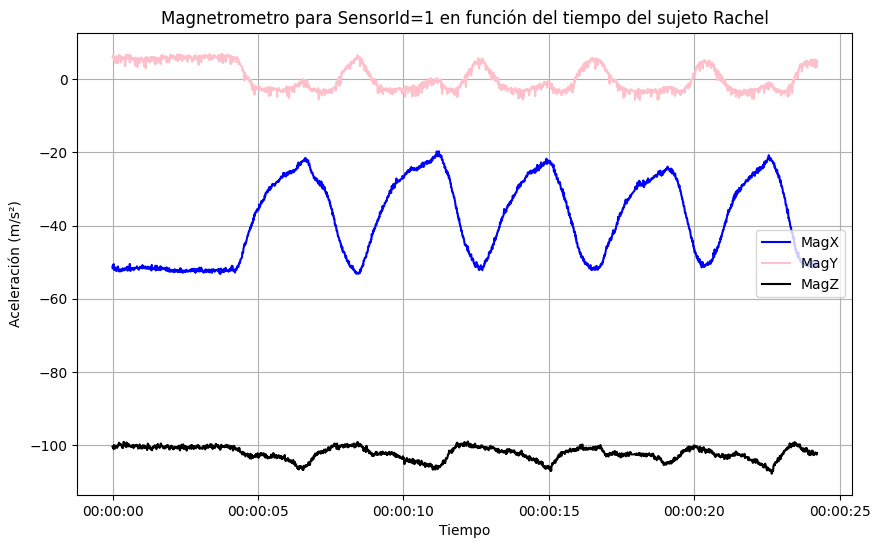

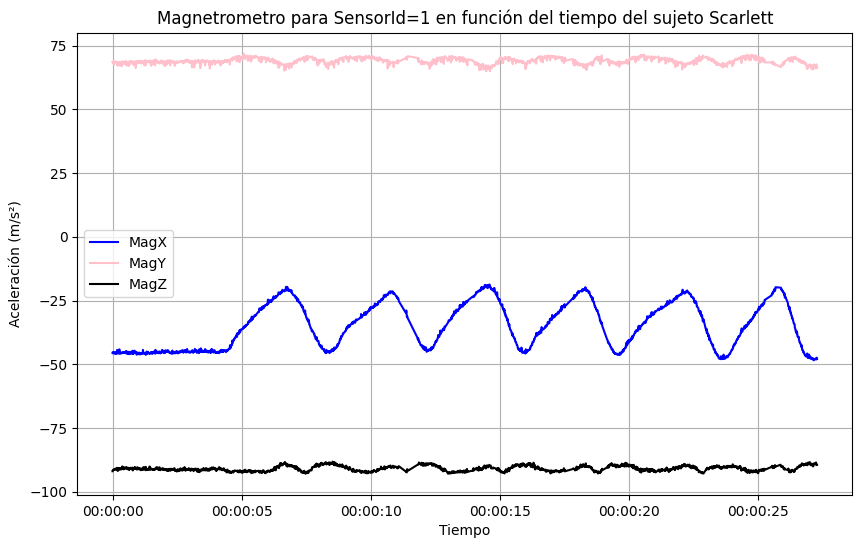

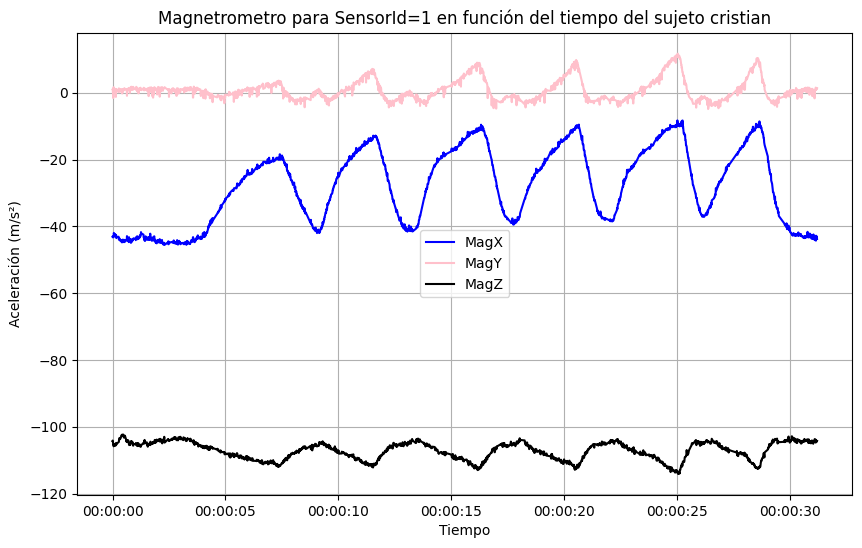

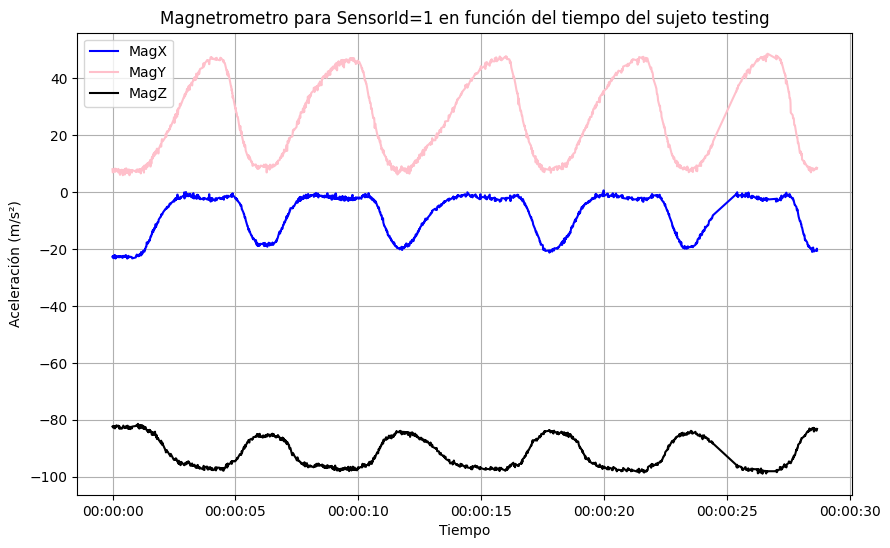

In [16]:
for index in list_df:
    df = list_df[index]
    
    df_sensor_id = df[df['SensorId'] == 1]  

    plt.figure(figsize=(10, 6))
    plt.plot(df_sensor_id['TimeStamp'], df_sensor_id['MagX'], label='MagX', color='blue')
    plt.plot(df_sensor_id['TimeStamp'], df_sensor_id['MagY'], label='MagY', color='pink')
    plt.plot(df_sensor_id['TimeStamp'], df_sensor_id['MagZ'], label='MagZ', color='black')
    plt.title(f'Magnetrometro para SensorId=1 en función del tiempo del sujeto {index}')
    plt.xlabel('Tiempo')
    plt.ylabel('Aceleración (m/s²)')
    plt.legend()
    plt.grid(True)
    plt.show()

## Segmentacion de la visualizaci&oacute;n

En esta secci&oacute;n se encargo de segmentar los tiempos de ejecuci&oacute;n de las sentadillas hechas por los voluntarios, para asi tener un control de que tomar en cuenta al momento de extraer las caracter&iacute;sticas.

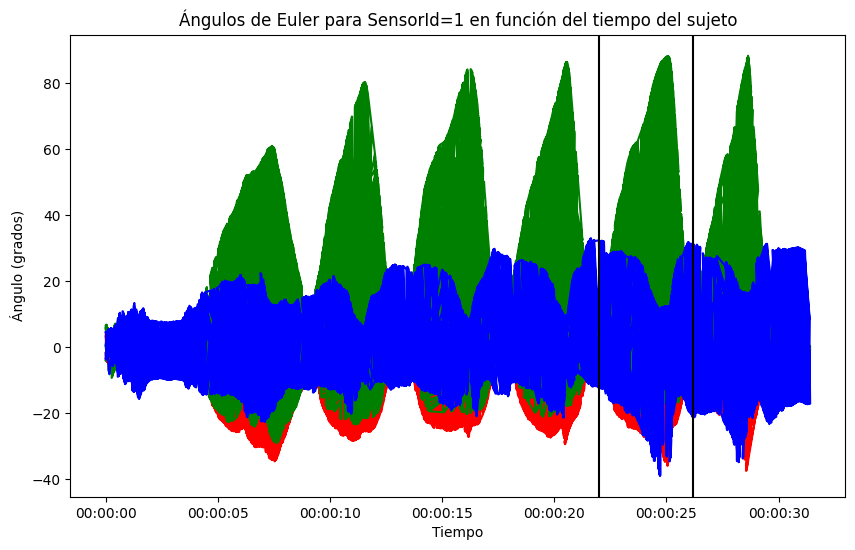

In [17]:
df_sensor_id = list_df["cristian"]
start_time = 22 # Tiempo donde empieza la sentadilla
end_time = 26.2 # Tiempo donde termina la sentadilla

start_time = pd.to_datetime(start_time, unit='s')
end_time = pd.to_datetime(end_time, unit='s')

# Filtrar los datos para la ventana de tiempo deseada
mask = (df['TimeStamp'] >= start_time) & (df['TimeStamp'] <= end_time)
df_time_window = df.loc[mask]
# Graficar los ángulos de Euler en función del tiempo para SensorId igual a 1
plt.figure(figsize=(10, 6))
plt.plot(df_sensor_id['TimeStamp'], df_sensor_id['EulerX'], label='EulerX', color='red')
plt.plot(df_sensor_id['TimeStamp'], df_sensor_id['EulerY'], label='EulerY', color='green')
plt.plot(df_sensor_id['TimeStamp'], df_sensor_id['EulerZ'], label='EulerZ', color='blue')
plt.axvline(x=start_time, color='black', linestyle='-', label='Tiempo Establecido')
plt.axvline(x=end_time, color='black', linestyle='-', label='Tiempo Establecido')
plt.title(f'Ángulos de Euler para SensorId=1 en función del tiempo del sujeto')
plt.xlabel('Tiempo')
plt.ylabel('Ángulo (grados)')
plt.show()

In [18]:
folder = "./Segmentado/"
dir_list = os.listdir(folder)
dir_list.sort()
segmentado_df = []
for i in dir_list:
    df = pd.read_csv(folder + i)
    segmentado_df.append(df)

segmentado_df = pd.concat(segmentado_df)
segmentado_df.reset_index(drop=True, inplace=True)
segmentado_df

subject  rep  inicio   fin  label
0     Ariana    1     3.6   7.6      2
1     Ariana    2     8.1  12.2      0
2     Ariana    3    12.4  16.0      0
3     Ariana    4    16.2  19.5      0
4   Jonathan    1     3.3   8.5      2
5   Jonathan    2     8.6  12.8      2
6   Jonathan    3    13.0  17.2      2
7   Jonathan    4    17.4  21.6      2
8   Jonathan    5    21.8  25.5      2
9   cristian    1     4.5   9.0      2
10  cristian    2     9.1  12.9      2
11  cristian    3    13.2  17.6      2
12  cristian    4    17.9  21.7      2
13  cristian    5    22.0  26.2      2
14      Juan    1     2.8   8.0      2
15      Juan    2     8.3  13.0      2
16      Juan    3    14.0  18.0      0
17      Juan    4    18.5  23.0      2
18      Juan    5    23.3  28.0      2
19     Leydy    1     5.8  10.0      0
20     Leydy    2    10.3  14.0      0
21     Leydy    3    14.3  18.3      2
22     Leydy    4    19.0  23.4      2
23     Leydy    5    25.0  28.8      0
24    Rachel    1     4.1   8.2      1
25    Rachel    2     8.4  12.2      2
26    Rachel    3    12.6  16.5      1
27    Rachel    4    16.7  20.4      1
28    Rachel    5    20.6  23.6      1
29    Andrea    1     4.2   9.0      2
30    Andrea    2     9.6  14.0      2
31    Andrea    3    14.8  18.5      2
32    Andres    1     3.0   7.0      2
33    Andres    2     8.0  11.8      2
34    Andres    3    12.0  16.0      2
35    Andres    4    16.4  19.5      2
36    Andres    5    20.0  23.0      2
37  Scarlett    1     4.3   8.2      1
38  Scarlett    2     8.5  12.0      1
39  Scarlett    3    12.5  15.8      1
40  Scarlett    4    16.0  19.5      1
41  Scarlett    5    19.8  23.6      1

In [19]:
indice_para_excluir = 9 
list_df_filtrada = [df for i, df in enumerate(list_df) if i != indice_para_excluir]

Se muestra a continuaci&oacute;n como se fueron segmentando los tiempos para calcular cuando se hacia la sentadilla por persona.

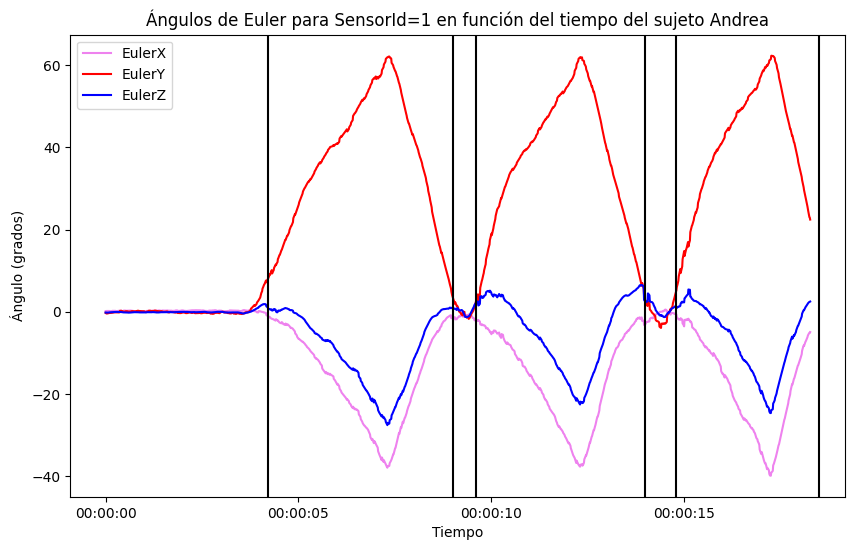

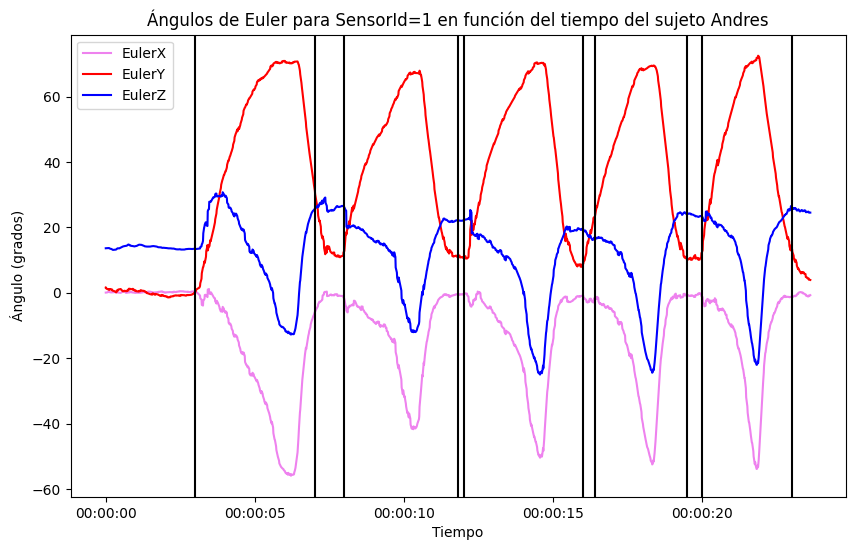

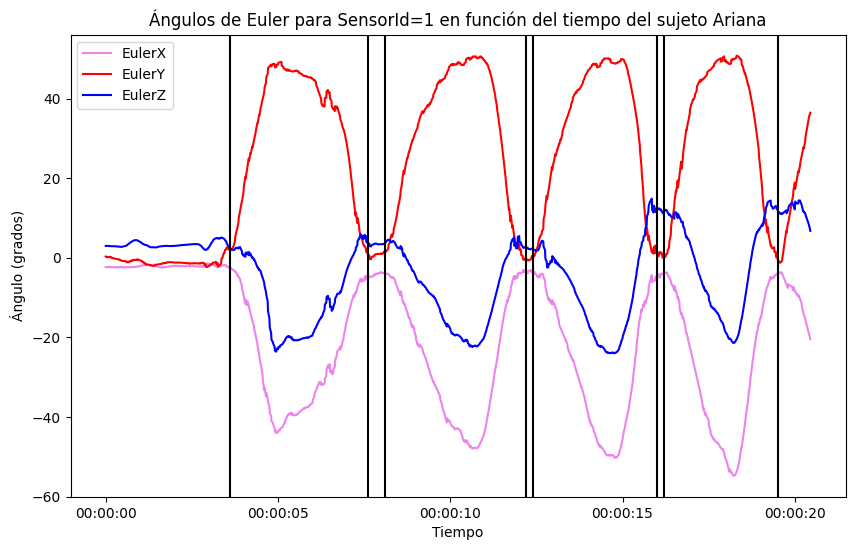

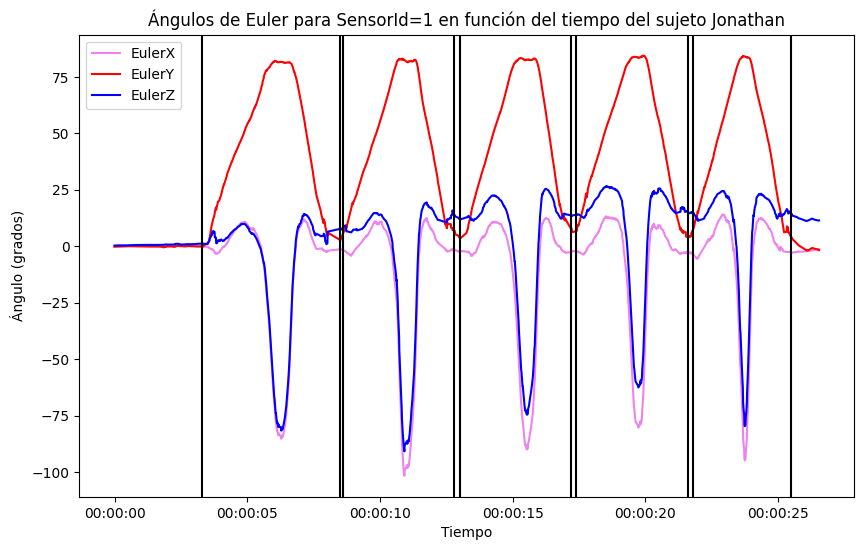

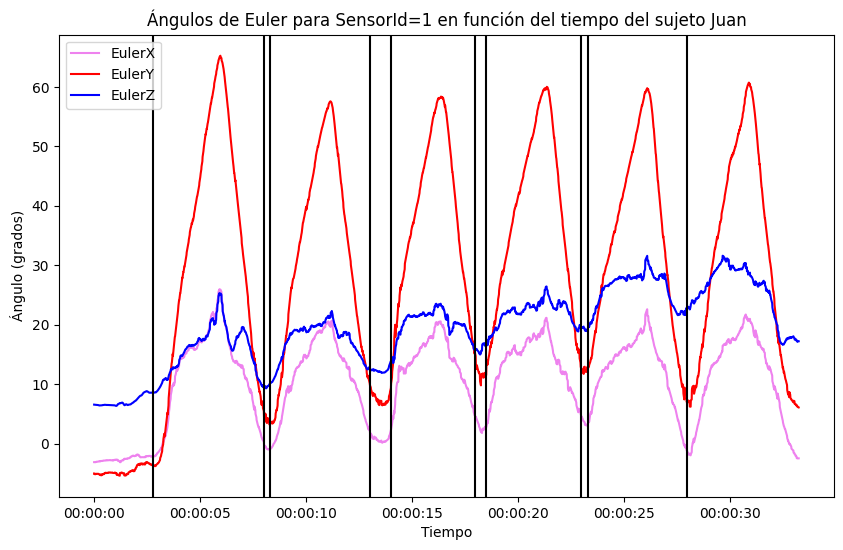

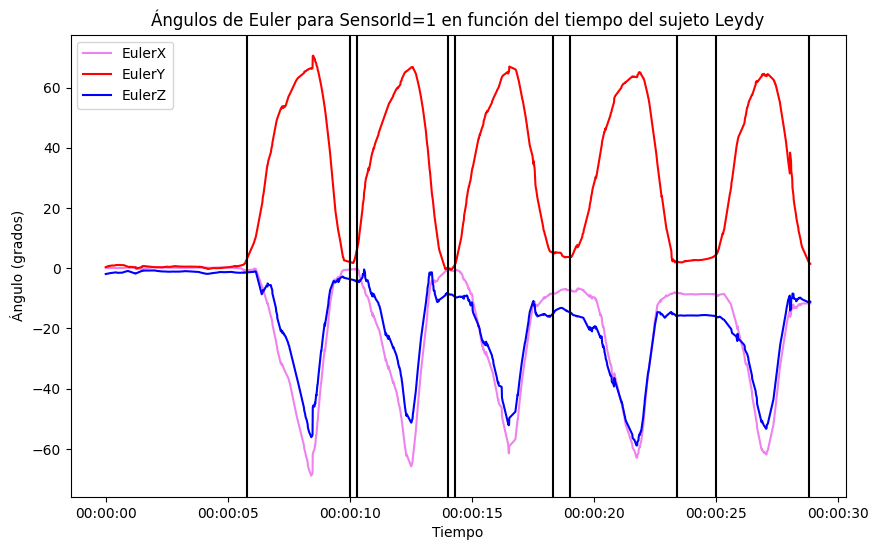

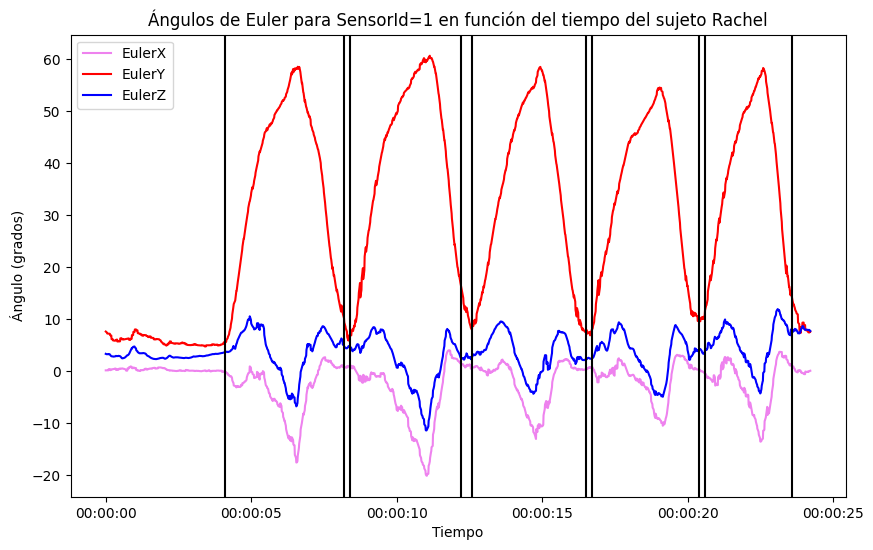

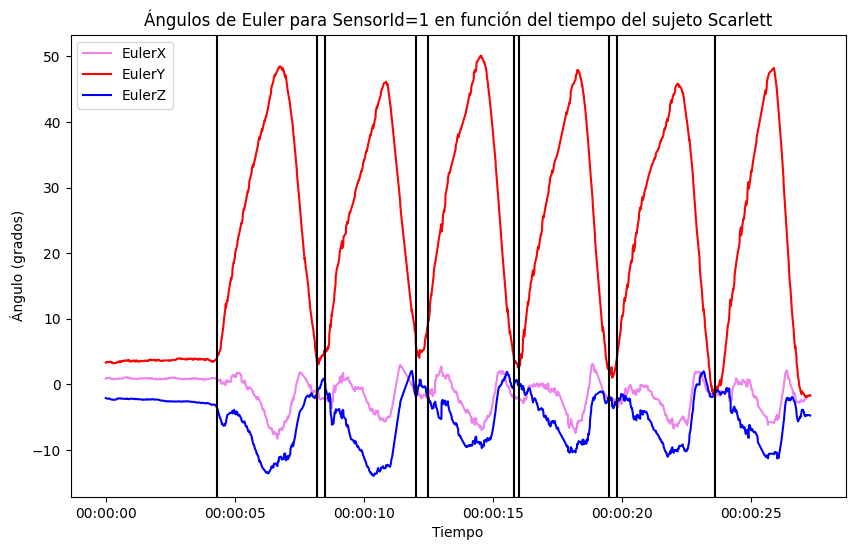

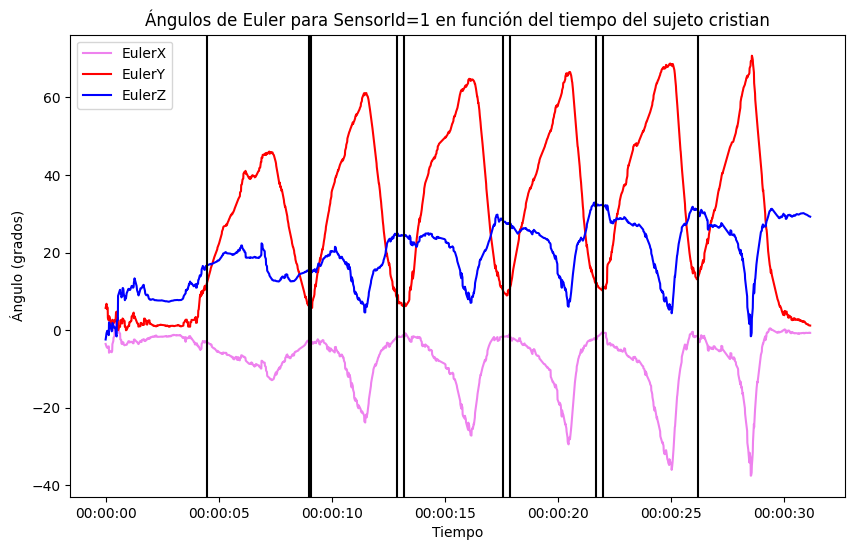

In [20]:
for index in list_df_filtrada:
    df = list_df[index]
    # Filtrar los datos por SensorId 
    df_sensor_id = df[df["SensorId"] == 1]
    segmentos = segmentado_df[segmentado_df["subject"] == index]
    # Suponiendo que start_time y end_time son valores en segundo
    # Graficar los ángulos de Euler en función del tiempo para SensorId igual a 1
    plt.figure(figsize=(10, 6))
    plt.plot(df_sensor_id['TimeStamp'], df_sensor_id['EulerX'], label='EulerX', color='violet')
    plt.plot(df_sensor_id['TimeStamp'], df_sensor_id['EulerY'], label='EulerY', color='red')
    plt.plot(df_sensor_id['TimeStamp'], df_sensor_id['EulerZ'], label='EulerZ', color='blue')
    for i, row in segmentos.iterrows():
        start_time = row["inicio"]
        end_time = row["fin"]
        start_time = pd.to_datetime(start_time, unit='s')
        end_time = pd.to_datetime(end_time, unit='s')
        plt.axvline(x=start_time, color='black', linestyle='-')
        plt.axvline(x=end_time, color='black', linestyle='-')
    plt.title(f'Ángulos de Euler para SensorId=1 en función del tiempo del sujeto {index}')
    plt.xlabel('Tiempo')
    plt.ylabel('Ángulo (grados)')
    plt.legend()
    plt.show()

In [21]:
# Suponiendo que list_df es un diccionario de DataFrames y segmentado_df es otro DataFrame
# Preparar un diccionario para almacenar los datos de los segmentos con sus etiquetas
segment_data = {}

for index in list_df:
    df = list_df[index]
    segmentos = segmentado_df[segmentado_df["subject"] == index]
    
    # Lista para almacenar datos de segmentos para este sujeto
    segment_data[index] = []
    
    for i, row in segmentos.iterrows():
        start_time = row["inicio"]
        end_time = row["fin"]
        label = row["label"]  # Etiqueta del segmento actual
        start_time = pd.to_datetime(start_time, unit='s')
        end_time = pd.to_datetime(end_time, unit='s')
        
        segment_df = df[(df['TimeStamp'] >= start_time) & (df['TimeStamp'] <= end_time)].copy()
        segment_df['label'] = label
        
        # Almacenar los datos filtrados del segmento junto con su etiqueta
        segment_data[index].append(segment_df)

## Extracci&oacute;n de Caracter&iacute;sticas

En base a los segmentos seleccionados previamente, se comienza a extraer las caracter&iacute;sticas para poder entreenar al modelo posteriormente.

In [22]:
import tsfel
import pandas as pd

# Obtener la configuración por defecto de TSFEL para la extracción de características temporales
cfg = tsfel.get_features_by_domain("temporal")

# Inicializar un DataFrame vacío para los vectores de características
features_df = pd.DataFrame()

# Suponer que segment_data es un diccionario con los segmentos de datos de cada sujeto,
# donde cada segmento ya tiene asociada su etiqueta 'label'.
for subject, segments in segment_data.items():
    for segment_df in segments:
        # Asegurarse de que el DataFrame del segmento contenga las columnas requeridas
        if all(column in segment_df.columns for column in ['AccTotal', 'GyroTotal', 'MagTotal', 'EulerTotal']):
            # Seleccionar solo las columnas de interés y convertirlas a un formato adecuado para TSFEL
            segment_data = segment_df[['AccTotal', 'GyroTotal', 'MagTotal', 'EulerTotal']].values

            # Calcular las características para este segmento
            features = tsfel.time_series_features_extractor(cfg, segment_data, fs=1)
            
            # Verificar si 'features' es un DataFrame y luego añadir la etiqueta del segmento
            if isinstance(features, pd.DataFrame):
                # Añadir la etiqueta del segmento de manera segura
                features['label'] = segment_df['label'].iloc[0]  
                # Concatenar con el DataFrame de características
                features_df = pd.concat([features_df, features], ignore_index=True)

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


Guardamos los datos en un archivo .csv para tener un mejor manejo de los datos.

In [23]:
features_df.to_csv("features.csv")

In [24]:
df = pd.read_csv("features.csv")
print(df.head())

   Unnamed: 0  0_Area under the curve  0_Autocorrelation  0_Centroid  \
0           0             1775.878061        1783.370903  886.503389   
1           1             1651.298230        1658.265918  823.668096   
2           2             1359.446282        1368.122144  678.902350   
3           3             1332.257687        1338.668933  665.507856   
4           4             1372.480576        1380.421986  682.325602   

   0_Mean absolute diff  0_Mean diff  0_Median absolute diff  0_Median diff  \
0              0.021175     0.000016                0.012181      -0.000302   
1              0.023487    -0.000004                0.014201      -0.000532   
2              0.028384     0.000016                0.015115      -0.000097   
3              0.018348    -0.000075                0.011903      -0.000128   
4              0.021740     0.000018                0.014078      -0.000657   

   0_Negative turning points  0_Neighbourhood peaks  ...  \
0                      473.0    

In [25]:
df = df.drop(['Unnamed: 0'], axis=1)
X = df.iloc[:, 1:-1]
Y = df.iloc[:, -1]

### Info Gain

Aqui se aplica la ganancia de informaci&oacute;n para poder extraer las caracter&iacute;sticas que sean mas convenientes para el an&aacute;lisis y posterior uso en el entrenamiento.

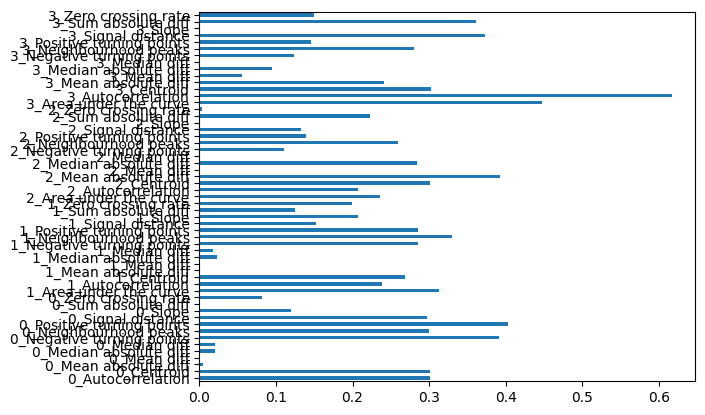

In [26]:
from sklearn.feature_selection import mutual_info_classif


# Asumiendo que X y y ya están definidos como se discutió anteriormente
X_new = mutual_info_classif(X, Y)

# Ajusta las etiquetas de las columnas para que coincidan con las dimensiones de X
# Aquí, utilizamos df.columns[1:-1] para excluir tanto la primera como la última columna de df
feat_imp = pd.Series(X_new, df.columns[1:len(df.columns)-1])

# Graficar la importancia de las características
feat_imp.plot(kind='barh')
plt.show()

In [28]:
# Calcular el valor medio entre 0.2 y 0.3
umbral = (0.2 + 0.3) / 2

# Filtrar las características con valores mayores al umbral
selected_features = features_df.columns[np.where(X_new > umbral)].tolist()

# Mostrar las características seleccionadas
print("Características seleccionadas con valor mayor a", umbral, ":", selected_features)
features_df_info_gain = features_df[selected_features]
features_df_info_gain

Características seleccionadas con valor mayor a 0.25 : ['0_Area under the curve', '0_Autocorrelation', '0_Median diff', '0_Negative turning points', '0_Neighbourhood peaks', '0_Positive turning points', '0_Zero crossing rate', '1_Autocorrelation', '1_Median diff', '1_Negative turning points', '1_Neighbourhood peaks', '2_Autocorrelation', '2_Centroid', '2_Mean diff', '2_Negative turning points', '2_Zero crossing rate', '3_Area under the curve', '3_Autocorrelation', '3_Negative turning points', '3_Positive turning points', '3_Slope']


0_Area under the curve  0_Autocorrelation  0_Median diff  \
0              1775.878061        1783.370903  -3.017534e-04   
1              1651.298230        1658.265918  -5.322836e-04   
2              1359.446282        1368.122144  -9.711450e-05   
3              1332.257687        1338.668933  -1.284022e-04   
4              1372.480576        1380.421986  -6.565360e-04   
5              1412.255959        1422.332537   2.051920e-04   
6              1128.558100        1136.544357   3.436402e-04   
7              1070.078467        1078.851678  -6.580577e-04   
8               972.558279         978.354682  -8.675982e-04   
9               975.054489         978.774836  -4.366487e-04   
10              792.743596         798.239320  -8.999477e-04   
11              659.401391         664.742757  -7.732183e-04   
12             2050.908212        2056.820463   0.000000e+00   
13             1660.529402        1679.635871   0.000000e+00   
14             1651.813863        1664.761021  -1.250537e-04   
15             1609.973216        1619.190422  -8.041441e-07   
16             1489.908210        1501.942797  -4.143800e-04   
17             1473.912373        1479.218875  -7.728057e-05   
18             1165.677937        1167.694295  -3.465727e-04   
19             1150.140473        1154.537774  -3.610312e-04   
20             1302.184011        1306.778523  -5.100407e-05   
21             1168.401752        1174.337267   4.140658e-04   
22              962.882057         966.225312  -3.853153e-05   
23              886.441809         888.511092  -2.211210e-04   
24              883.076261         887.970603   6.503919e-05   
25             1006.429177        1009.624936   1.115311e-04   
26              796.787107         799.057825  -2.331647e-04   
27             1090.366457        1095.019126   4.509316e-05   
28             1052.043570        1057.887120   7.026431e-04   
29             1080.541248        1085.277738  -2.490596e-04   
30             1046.763714        1052.284122  -7.795147e-05   
31              813.384355         819.446270   1.741444e-04   
32             1057.094970        1057.897064  -3.043990e-04   
33              821.137415         824.451261   4.694179e-05   
34              906.664051         908.828339  -1.182132e-04   
35              944.474517         947.638451  -4.968747e-06   
36             1050.053826        1052.491616   6.396693e-04   
37             1429.783385        1439.483270   2.523310e-04   
38             1171.674893        1178.324005  -8.093857e-04   
39             1214.114463        1223.027674  -1.396641e-04   
40             1085.116025        1092.411972   1.431237e-03   
41             1288.229338        1296.921473  -3.876948e-04   

    0_Negative turning points  0_Neighbourhood peaks  \
0                       473.0                   83.0   
1                       410.0                   78.0   
2                       342.0                   65.0   
3                       363.0                   67.0   
4                       367.0                   59.0   
5                       383.0                   59.0   
6                       296.0                   48.0   
7                       285.0                   47.0   
8                       230.0                   38.0   
9                       244.0                   36.0   
10                      191.0                   25.0   
11                      197.0                   20.0   
12                      464.0                   85.0   
13                      334.0                   62.0   
14                      367.0                   70.0   
15                      321.0                   69.0   
16                      330.0                   57.0   
17                      387.0                   65.0   
18                      295.0                   46.0   
19                      298.0                   51.0   
20                      342.0                   54.0   
21                 

## Modelos a Evaluar

En esta secci&oacute;n se seleccionan los clasificadores para poder probarlos y ver cual es el que conviene mas para entrenar el modelo.

In [29]:
X= features_df_info_gain
encoder = LabelEncoder()
y_encode = encoder.fit_transform(Y)
y_encode

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2,
       0, 0, 2, 2, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2],
      dtype=int64)

In [30]:
names = [
    "Nearest Neighbors",
    "Naive Bayes",
    "AdaBoost"
]
modelos = [
    KNeighborsClassifier(n_neighbors=6),
    GaussianNB(),
    AdaBoostClassifier()
]

In [31]:
def validacion_cruzada(model, X, y):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    precision_scores = []
    recall_scores = []
    f1_scores = []
    accuracies = []

    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)

        X_test_np = X_test.values
        y_pred = model.predict(X_test_np)

        precision = precision_score(y_test, y_pred, average='weighted')
        precision_scores.append(precision)

        recall = recall_score(y_test, y_pred, average='weighted')
        recall_scores.append(recall)

        f1 = f1_score(y_test, y_pred, average='weighted')
        f1_scores.append(f1)

        accuracy = model.score(X_test, y_test)
        accuracies.append(accuracy)

    return np.mean(precision_scores), np.mean(recall_scores), np.mean(f1_scores), np.mean(accuracies)

resultados = []

for nombre, modelo in zip(names, modelos):
    precision, recall, f1, accuracy = validacion_cruzada(model=modelo, X=X, y=y_encode)
    resultados.append({"nombre": nombre, "precision": precision, "recall": recall, "f1_score": f1, "accuracy": accuracy})

df_resultados = pd.DataFrame(resultados)

In [32]:
df_resultados

nombre  precision    recall  f1_score  accuracy
0  Nearest Neighbors   0.756019  0.694444  0.695074  0.694444
1        Naive Bayes   0.906019  0.883333  0.885993  0.883333
2           AdaBoost   0.696032  0.744444  0.708072  0.744444

## Entrenando el mejor modelo

En este caso, el modelo Naive Bayes fue el que resulto con un puntaje m&aacute;s alto que los dem&aacute;s, obteniendo 90. Por lo cual se decidi&oacute; utilizar este para entrenar el modelo.

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encode, test_size=0.2, random_state=42)
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

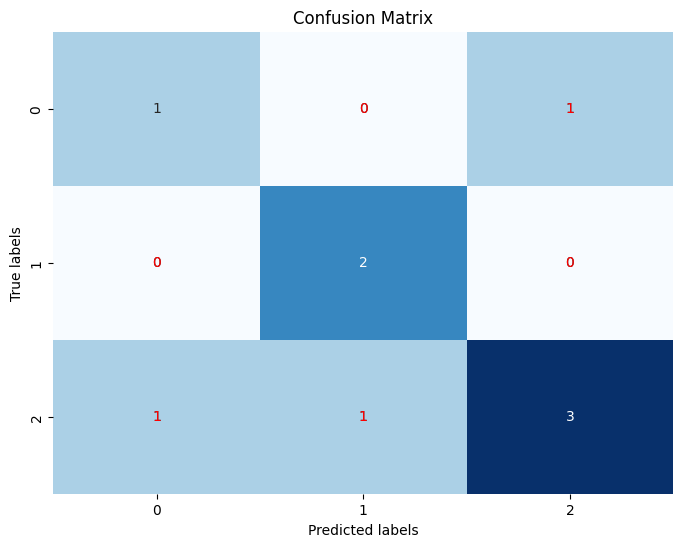

F1 Score: 0.6592592592592592
Sensibilidad (Recall): 0.6666666666666666
Especificidad por clase: [0.8571428571428571, 0.8571428571428571, 0.75]
Exactitud: 0.6666666666666666


In [34]:
# Obtener predicciones del modelo
y_pred = model.predict(X_test)

# Calcular la matriz de confusión multiclase
conf_matrix = confusion_matrix(y_test, y_pred)

# Calcular métricas adicionales
f1 = f1_score(y_test, y_pred, average='weighted')
sensibilidad = recall_score(y_test, y_pred, average='weighted')
exactitud = accuracy_score(y_test, y_pred)

# Calcular especificidad para cada clase
especificidad = []
for i in range(len(conf_matrix)):
    true_negative = np.sum(np.delete(np.delete(conf_matrix, i, 0), i, 1))
    total_negative = np.sum(np.delete(conf_matrix, i, 0))
    especificidad.append(true_negative / total_negative)

# Visualizar la matriz de confusión con un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)

# Resaltar los valores donde el modelo se confundió
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix)):
        if i != j:
            plt.text(j + 0.5, i + 0.5, conf_matrix[i, j], ha="center", va="center", color="red")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Imprimir métricas
print("F1 Score:", f1)
print("Sensibilidad (Recall):", sensibilidad)
print("Especificidad por clase:", especificidad)
print("Exactitud:", exactitud)

## Validaci&oacute;n

Aqui se utiliza el documento de validaci&oacute;n para ver si el modelo cumple correctamente con la clasificaci&oacute;n, por lo cual a los datos se le aplicar&aacute; el mismo tratamiento, pasar&aacute; por el mejor modelo y se ver&aacute; el resultado.

In [52]:
validacion_df = pd.read_csv("./validacion.csv")

In [53]:
columnas = validacion_df.columns
validacion_df.columns = [col.replace(' ', '').split('(')[0] for col in columnas]
validacion_df['TimeStamp'] = pd.to_datetime(validacion_df['TimeStamp'], unit='s')
# Features para analizar
validacion_df = validacion_df[['SensorId', 'TimeStamp', 'FrameNumber', 'AccX', 'AccY', 'AccZ', 'GyroX','GyroY', 'GyroZ', 'MagX', 'MagY', 'MagZ', 'EulerX', 'EulerY', 'EulerZ']]

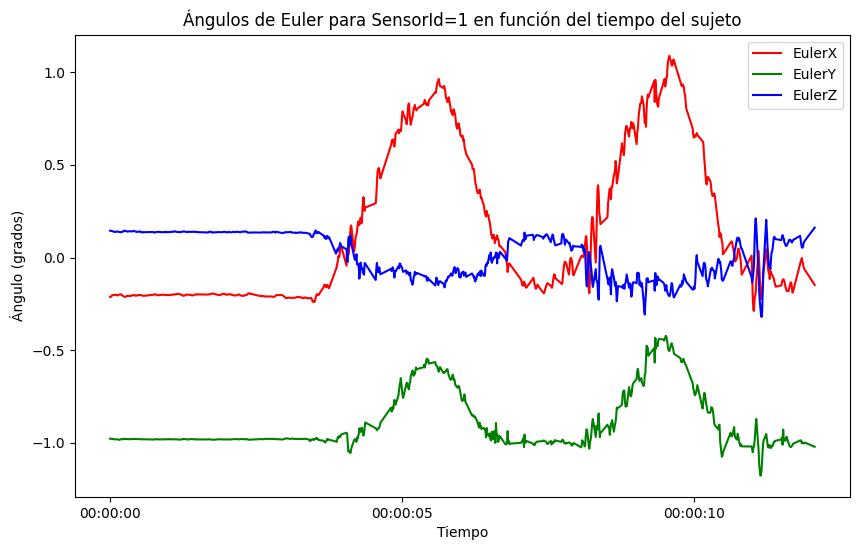

In [54]:
df_sensor_id = validacion_df[validacion_df["SensorId"] == 1]
plt.figure(figsize=(10, 6))
plt.plot(df_sensor_id['TimeStamp'], df_sensor_id['AccX'], label='EulerX', color='red')
plt.plot(df_sensor_id['TimeStamp'], df_sensor_id['AccY'], label='EulerY', color='green')
plt.plot(df_sensor_id['TimeStamp'], df_sensor_id['AccZ'], label='EulerZ', color='blue')
plt.title(f'Ángulos de Euler para SensorId=1 en función del tiempo del sujeto')
plt.xlabel('Tiempo')
plt.ylabel('Ángulo (grados)')
plt.legend()
plt.show()

In [55]:
validacion_df['AccTotal'] = np.sqrt(validacion_df['AccX']**2 + validacion_df['AccY']**2 + validacion_df['AccZ']**2)
validacion_df['GyroTotal'] = np.sqrt(validacion_df['GyroX']**2 + validacion_df['GyroY']**2 + validacion_df['GyroZ']**2)
validacion_df['MagTotal'] = np.sqrt(validacion_df['MagX']**2 + validacion_df['MagY']**2 + validacion_df['MagZ']**2)
validacion_df['EulerTotal'] = np.sqrt(validacion_df['EulerX']**2 + validacion_df['EulerY']**2 + validacion_df['EulerZ']**2)

In [56]:
cfg = tsfel.get_features_by_domain("temporal")

# Inicializar un DataFrame vacío para los vectores de características de validación
validation_features_df = pd.DataFrame()

# Tamaño de cada segmento de sentadilla
num_squats = 5
squat_segment_size = len(validacion_df) // num_squats

# Extraer características para cada segmento de sentadilla
for squat in range(num_squats):
    start_idx = squat * squat_segment_size
    end_idx = (squat + 1) * squat_segment_size if squat < num_squats - 1 else len(validacion_df)
    segment_data = validacion_df.iloc[start_idx:end_idx][['AccTotal', 'GyroTotal', 'MagTotal', 'EulerTotal']].values
    features = tsfel.time_series_features_extractor(cfg, segment_data, fs=1)
    validation_features_df = pd.concat([validation_features_df, features], ignore_index=True)

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


In [57]:
validation_features_df = validation_features_df[selected_features]
validation_features_df

0_Area under the curve  0_Autocorrelation  0_Median diff  \
0              512.593249         515.204399       0.000071   
1              510.843703         511.737944      -0.000060   
2              516.311990         523.763135       0.000000   
3              505.694886         502.468856      -0.000238   
4              517.163326         526.872151       0.000259   

   0_Negative turning points  0_Neighbourhood peaks  \
0                      149.0                   25.0   
1                      137.0                   25.0   
2                      111.0                   23.0   
3                      127.0                   25.0   
4                      112.0                   24.0   

   0_Positive turning points  0_Zero crossing rate  1_Autocorrelation  \
0                      147.0                   0.0       6.520677e+02   
1                      137.0                   0.0       8.128062e+04   
2                      110.0                   0.0       4.937926e+05   
3                      129.0                   0.0       7.972487e+05   
4                      111.0                   0.0       1.134630e+06   

   1_Median diff  1_Negative turning points  ...  2_Autocorrelation  \
0      -0.003922                      128.0  ...       4.820223e+06   
1       0.020198                      124.0  ...       4.872207e+06   
2       0.000000                      104.0  ...       4.970567e+06   
3      -0.089262                      111.0  ...       5.258860e+06   
4       0.164474                       91.0  ...       5.702911e+06   

   2_Centroid  2_Mean diff  2_Negative turning points  2_Zero crossing rate  \
0  260.791386     0.042467                       79.0                   0.0   
1  254.512796     0.066674                       74.0                   0.0   
2  258.336162    -0.072780                       80.0                   0.0   
3  271.656116     0.024174                      104.0                   0.0   
4  248.403944    -0.023158                      111.0                   0.0   

   3_Area under the curve  3_Autocorrelation  3_Negative turning points  \
0             2535.468027       25185.337404                       49.0   
1             3384.629511       43510.004402                       52.0   
2            15489.435428      734296.208376                       49.0   
3            10153.151166      325588.818394                       69.0   
4            18044.137926      916169.355409                       85.0   

   3_Positive turning points   3_Slope  
0                       79.0  0.003353  
1                       80.0  0.003949  
2                       75.0  0.036724  
3                       80.0  0.058150  
4                       85.0 -0.131286  

[5 rows x 21 columns]

In [58]:
# Prediccion del modelo
predicted_labels = model.predict(validation_features_df)

In [59]:
for i, label in enumerate(predicted_labels):
    print(f"Sentadilla {i} predicción -> {label}")

Sentadilla 0 predicción -> 2
Sentadilla 1 predicción -> 2
Sentadilla 2 predicción -> 0
Sentadilla 3 predicción -> 0
Sentadilla 4 predicción -> 0


## Conclusiones

El modelo clasifica pero siento que si se hubieran utilizado todos los datos de los sensores le hubiera ido mucho mejor, pero se fue viendo que en algunos casos no se obtuvieron todos los datos. El trabajar con sensores se ve&iacute;a como algo habitual, pero conforme empezamos a recabar los datos y trabajar en el proyecto pude darme cuenta que trabajar con ellos es algo realmente laborioso, cansado y en algunos casos frustrante. 
Muchas veces los sensores se desconectaban de la nada, cuando seg&uacute;n nosotros funciono bien nos dimos cuenta que en algunos casos no senso ning&uacute;n tipo de informaci&oacute;n, la persona voluntaria hizo las sentadillas de forma que los datos se traslapaban entre si y no era tan visible, sobre todo la inexperiencia con el trabajo con este tipo de artefacto nos hizo tener muchas dificultades, haciendo que tuvieramos que reunirnos a trabajar para llegar a algo, de otra forma no se hubiera llegado a mucho.
 